# Setup

In [1]:
# List the necessary R packages
needed_packages <- c("tidyverse", "glue", "furrr", "ggrepel",
  "xgboost", "tidymodels", 
  "vip", "SHAPforxgboost", "shapviz",
  "reticulate",
  "tictoc"
  )

# Check if R packages are installed
installed_packages <- .packages(all.available = TRUE)
missing_packages <- needed_packages[!(needed_packages %in% installed_packages)]

# If any are missing, install them
if (length(missing_packages) > 0) {
  install.packages(
    missing_packages,
    repos = c(
      "https://cran.r-project.org"
      )
    )
}

In [2]:
# Load the required R packages
suppressMessages(invisible(lapply(needed_packages, library, character.only = TRUE)))

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘future’ was built under R version 4.3.3”
Warning message:
“package ‘broom’ was built under R version 4.3.3”
Warning message:
“package ‘recipes’ was built under R version 4.3.3”


In [3]:
# Use python version found in configuration from reticulate package
use_python(py_config()$python)

In [4]:
# Install the necessary Python packages if not already in environment
needed_python_packages <- c("google-cloud-aiplatform", "vertexai")

installed_python_packages <- py_list_packages()

missing_python_packages <- needed_python_packages[!(needed_python_packages
  %in% installed_python_packages)]

py_install(packages = missing_python_packages, pip = TRUE) 

In [5]:
# Set various options
# Shows all fields when printing tibble
options(tibble.width = Inf)

# Default height/width for plots generated in notebook
DEFAULT_PLOT_HEIGHT <- 9
DEFAULT_PLOT_WIDTH <- 16

options(repr.plot.height = DEFAULT_PLOT_HEIGHT, repr.plot.width = DEFAULT_PLOT_WIDTH)

In [6]:
# Update ggplot theme to use for various plots in this notebook
default_plot_theme <- theme(
  plot.title = element_text(size = 36, hjust = 0.5),
  axis.title = element_text(size = 30),
  axis.text = element_text(size = 24),
  strip.text = element_text(size = 30),
  legend.title = element_text(size = 30),
  legend.text = element_text(size = 24)
  )

theme_update(
  plot.title = element_text(size = 36, hjust = 0.5),
  axis.title = element_text(size = 30),
  axis.text = element_text(size = 24),
  strip.text = element_text(size = 30),
  legend.title = element_text(size = 30),
  legend.text = element_text(size = 24)
  )    

In [7]:
# Set Cloud project and Cloud Storage bucket parameters
PROJECT_ID <- "[YOUR_PROJECT_ID]"

REGION <- "[YOUR_REGION]"

BUCKET_NAME <- "[YOUR_BUCKET_NAME]"

BUCKET_SUBDIR <- "olympics"

In [8]:
# Set up Vertex AI library in Python
vertexai <- reticulate::import("vertexai")
vertexai$init(project = PROJECT_ID, location = REGION)

In [9]:
# Setup Gemini 1.5 Pro and 1.5 Flash models and other useful Gemini modules
GeminiProModel <- vertexai$generative_models$GenerativeModel("gemini-1.5-pro")

GeminiFlashModel <- vertexai$generative_models$GenerativeModel("gemini-1.5-flash")

GenerationConfig <- vertexai$generative_models$GenerationConfig

Part <- vertexai$generative_models$Part

In [10]:
# Functions to upload file and ggplot object to Cloud Storage
UploadFileToCloudStorageBucket <- function(file_name, bucket_name, bucket_subdir,
  project_id, check_output_dir_after_write = TRUE, delete_local_file = FALSE) 
{   
    bucket_uri <- glue("gs://{bucket_name}")

    make_bucket_command <- glue("gsutil mb -p {project_id} {bucket_uri}")

    system(make_bucket_command)

    output_dir <- glue("{bucket_uri}/{bucket_subdir}")

    file_output_command <- glue("gsutil cp {file_name} {output_dir}")

    system(file_output_command)

    if(check_output_dir_after_write)
    {
      check_output_command <- glue("gsutil ls -l {output_dir}")
      
      system(check_output_command, intern = TRUE) %>% cat()
    }
    
    if(delete_local_file)
    {
      file.remove(file_name)
    }
}

UploadGGPlotObjectToCloudStorageBucket <- function(plot_object, 
  file_name, bucket_name, bucket_subdir, project_id, 
  plot_scale = 1,
  check_output_dir_after_write = TRUE, 
  delete_local_file = FALSE
  )
{
  ggsave(
    filename = file_name, 
    plot = plot_object,
    scale = plot_scale,
    height = options()$repr.plot.height,
    width = options()$repr.plot.width,
    units = "in"
    )
    
  UploadFileToCloudStorageBucket(
    file_name = file_name,
    bucket_name = bucket_name,
    bucket_subdir = bucket_subdir,
    project_id = project_id,
    check_output_dir_after_write,
    delete_local_file
    )
}

# Read in and Process Country-Level Summer Olympic Medals Data

In [11]:
# Read in pre-2024 Olympics country year medal data, downloaded from Kaggle:
# https://www.kaggle.com/datasets/ramontanoeiro/summer-olympic-medals-1986-2020/data

country_year_medals <- read_csv(file = "1896_to_2021_summer_olympics_medals.csv") %>%
  print()

Rows: 1344 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Host_country, Host_city, Country_Name, Country_Code
dbl (4): Year, Gold, Silver, Bronze

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 1,344 × 8
    Year Host_country Host_city Country_Name  Country_Code  Gold Silver Bronze
   <dbl> <chr>        <chr>     <chr>         <chr>        <dbl>  <dbl>  <dbl>
 1  1896 Greece       Athens    Great Britain GBR              2      3      2
 2  1896 Greece       Athens    Hungary       HUN              2      1      3
 3  1896 Greece       Athens    France        FRA              5      4      2
 4  1896 Greece       Athens    United States USA             11      7      2
 5  1896 Greece       Athens    Germany       GER              6      5      2
 6  1896 Greece       Athens    Austria       AUT              2      1      2
 7  1896 Greece       Athens    Mixed team    ZZX              1      0      1
 8  1896 Greece       Athens    Greece        GRE             10     18     19
 9  1896 Greece       Athens    Switzerland   SUI              1      2      0
10  1896 Greece       Athens    Australia     AUS              2      0      0
# ℹ 1,334 more rows


In [12]:
# Read in 2024 countries data, from participating national Olympics committees on
# 2024 Olympics Wikipedia page: https://en.wikipedia.org/wiki/2024_Summer_Olympics
# This was created before 2024 Olympics, so does not include medal counts

countries_2024 <- read_csv(file = "2024_summer_olympics_countries.csv") %>%
  print()

Rows: 206 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Country
dbl (1): NumAthletes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 206 × 2
   Country             NumAthletes
   <chr>                     <dbl>
 1 Afghanistan                   6
 2 Albania                       8
 3 Algeria                      45
 4 American Samoa                2
 5 Andorra                       2
 6 Angola                       24
 7 Antigua and Barbuda           5
 8 Argentina                   136
 9 Armenia                      15
10 Aruba                         6
# ℹ 196 more rows


In [13]:
# Read in 2024 country medal data, which was created after 2024 Olympics
# Tabled copied from Wikipedia on 8/11/24 (day of closing ceremonies):
# https://en.wikipedia.org/wiki/2024_Summer_Olympics_medal_table#Medal_table
# Only includes countries with medals, not all participating ones

countries_2024_medals <- read_csv(file = "2024_summer_olympics_medals.csv") %>%
  print()

Rows: 92 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): NOC
dbl (4): Gold, Silver, Bronze, Total

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 92 × 5
   NOC            Gold Silver Bronze Total
   <chr>         <dbl>  <dbl>  <dbl> <dbl>
 1 United States    40     44     42   126
 2 China            40     27     24    91
 3 Japan            20     12     13    45
 4 Australia        18     19     16    53
 5 France           16     26     22    64
 6 Netherlands      15      7     12    34
 7 Great Britain    14     22     29    65
 8 South Korea      13      9     10    32
 9 Italy            12     13     15    40
10 Germany          12     13      8    33
# ℹ 82 more rows


In [14]:
# Build out 2024 data into table to bind with previous years data (including countries w/o medals)
countries_2024_with_medals <- countries_2024 %>%
  left_join(
    countries_2024_medals %>% 
      select(Country = NOC, Gold, Silver, Bronze),
    by = "Country"
    ) %>%
  transmute(
    Year = 2024L,
    HostCountry = "France",
    HostCity = "Paris",
    Country,
    across(
      c(Gold, Silver, Bronze),
      ~ ifelse(is.na(.x), 0L, as.integer(.x))
      )
    ) %>%
  print()

# A tibble: 206 × 7
    Year HostCountry HostCity Country              Gold Silver Bronze
   <int> <chr>       <chr>    <chr>               <int>  <int>  <int>
 1  2024 France      Paris    Afghanistan             0      0      0
 2  2024 France      Paris    Albania                 0      0      2
 3  2024 France      Paris    Algeria                 2      0      1
 4  2024 France      Paris    American Samoa          0      0      0
 5  2024 France      Paris    Andorra                 0      0      0
 6  2024 France      Paris    Angola                  0      0      0
 7  2024 France      Paris    Antigua and Barbuda     0      0      0
 8  2024 France      Paris    Argentina               1      1      1
 9  2024 France      Paris    Armenia                 0      3      1
10  2024 France      Paris    Aruba                   0      0      0
# ℹ 196 more rows


In [15]:
# Read in country level info found by mapping IOC codes to World Bank country
# codes, looking up country's languages supported by Gemini in Wikipedia, etc.
country_mapping_and_info <- read_csv(file = "country_mapping_and_info.csv") %>%
  print()

Rows: 220 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): OlympicsCountry, OlympicsCountryCode, OlympicsCountryGroup, WorldBa...
lgl (1): In2024

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 220 × 6
   OlympicsCountry     OlympicsCountryCode OlympicsCountryGroup
   <chr>               <chr>               <chr>               
 1 Afghanistan         AFG                 AFG                 
 2 Albania             ALB                 ALB                 
 3 Algeria             ALG                 ALG                 
 4 American Samoa      ASA                 ASA                 
 5 Andorra             AND                 AND                 
 6 Angola              ANG                 ANG                 
 7 Antigua and Barbuda ANT                 ANT                 
 8 Argentina           ARG                 ARG                 
 9 Armenia             ARM                 ARM                 
10 Aruba               ARU                 ARU                 
   WorldBankCountryCode GeminiSupportedLanguage In2024
   <chr>                <chr>                   <lgl> 
 1 AFG                  NA                      TRUE  
 2 ALB                  NA                     

In [16]:
# Put together all country year medals info, starting with a more "modern" year
START_YEAR_FOR_DATA <- 1984

country_year_medals_with_info <- country_year_medals %>%
  # Removing original Country_Code as it's missing for 2016
  select(-Country_Code) %>%
  rename(
    HostCountry = Host_country,
    HostCity = Host_city,
    Country = Country_Name
    ) %>%
  mutate(
    across(
      c("Year", "Gold", "Silver", "Bronze"),
      as.integer
    )) %>%
  filter(Year >= START_YEAR_FOR_DATA) %>%
  bind_rows(countries_2024_with_medals) %>%
  # Join to get Olympic country codes
  left_join(
    country_mapping_and_info %>%
      select(Country = OlympicsCountry, OlympicsCountryCode,
        OlympicsCountryGroup),
    by = c("Country")
    ) %>%
  print()

# A tibble: 954 × 9
    Year HostCountry   HostCity    Country             Gold Silver Bronze
   <int> <chr>         <chr>       <chr>              <int>  <int>  <int>
 1  1984 United States Los Angeles Colombia               0      1      0
 2  1984 United States Los Angeles Puerto Rico            0      1      1
 3  1984 United States Los Angeles United States         83     61     30
 4  1984 United States Los Angeles Romania               20     16     17
 5  1984 United States Los Angeles Zambia                 0      0      1
 6  1984 United States Los Angeles Dominican Republic     0      0      1
 7  1984 United States Los Angeles Iceland                0      0      1
 8  1984 United States Los Angeles West Germany          17     19     23
 9  1984 United States Los Angeles Japan                 10      8     14
10  1984 United States Los Angeles New Zealand            8      1      2
   OlympicsCountryCode OlympicsCountryGroup
   <chr>               <chr>               
 1 C

In [17]:
# Pull out hosts by year from country year medals data
olympic_year_hosts <- country_year_medals %>%
  transmute(
    Year = as.integer(Year), 
    HostCountry = Host_country, 
    HostCity = Host_city
    ) %>%
  # Add in row for 2024 Olympics in Paris if not present in data
  bind_rows(
    tibble(Year = 2024L, HostCountry = "France", HostCity = "Paris")
    ) %>%
  distinct(Year, HostCountry, HostCity) %>%
  arrange(desc(Year)) %>%
  print()

# A tibble: 30 × 3
    Year HostCountry   HostCity      
   <int> <chr>         <chr>         
 1  2024 France        Paris         
 2  2020 Japan         Tokyo         
 3  2016 Brazil        Rio de Janeiro
 4  2012 Great Britain London        
 5  2008 China         Beijing       
 6  2004 Greece        Athens        
 7  2000 Australia     Sydney        
 8  1996 United States Atlanta       
 9  1992 Spain         Barcelona     
10  1988 South Korea   Seoul         
# ℹ 20 more rows


In [18]:
# Look at Olympic country "groups" to track different countries by year
olympic_groups <- country_year_medals_with_info %>%
  group_by(OlympicsCountryGroup) %>%
  arrange(Year) %>%
  summarize(
    FirstYear = min(Year),
    LastYear = max(Year),
    LastCountryName = last(Country),
    LastOlympicsCountryCode = last(OlympicsCountryCode)
    ) %>%
  ungroup() %>%
  print()

# A tibble: 213 × 5
   OlympicsCountryGroup FirstYear LastYear LastCountryName            
   <chr>                    <int>    <int> <chr>                      
 1 AFG                       2008     2024 Afghanistan                
 2 AHO                       1988     1988 Netherlands Antilles       
 3 AIN                       2024     2024 Individual Neutral Athletes
 4 ALB                       2024     2024 Albania                    
 5 ALG                       1984     2024 Algeria                    
 6 AND                       2024     2024 Andorra                    
 7 ANG                       2024     2024 Angola                     
 8 ANT                       2024     2024 Antigua and Barbuda        
 9 ARG                       1988     2024 Argentina                  
10 ARM                       1996     2024 Armenia                    
   LastOlympicsCountryCode
   <chr>                  
 1 AFG                    
 2 AHO                    
 3 AIN              

In [19]:
# Merge and process various different country-level medals data
country_year_medals_plus <- country_year_medals_with_info %>%
  mutate(
    IsHostCountry = (HostCountry == Country)
    ) %>%
  select(-HostCountry, -HostCity) %>%
  complete(
    Year, OlympicsCountryGroup,
    fill = list(IsHostCountry = FALSE)
    ) %>%
  # Fill in 0 for each medal type in years prior to 2024
  mutate(
    across(c("Gold", "Silver", "Bronze"),
      ~ifelse(Year < 2024 & is.na(.), 0L, .)
      )   
    ) %>%
  left_join(
    olympic_groups %>% 
      rename(CountryFirstYear = FirstYear, CountryLastYear = LastYear),
    by = "OlympicsCountryGroup"
    ) %>%
  # Filter country rows to "relevant" years only (based on being in medal tables for year)
  filter(
    Year >= CountryFirstYear,
    Year <= CountryLastYear
    ) %>%
  # Fill in missing country names and codes as necessary
  mutate(
    Country = ifelse(is.na(Country), LastCountryName, Country),
    OlympicsCountryCode = ifelse(is.na(OlympicsCountryCode), LastOlympicsCountryCode,
      OlympicsCountryCode)
    ) %>%
  select(Year, Country, OlympicsCountryCode, OlympicsCountryGroup, IsHostCountry,
    everything(),
    -CountryFirstYear, -CountryLastYear, -LastCountryName, -LastOlympicsCountryCode
    ) %>%
  # Add in total medal count
  mutate(
    Medals = Gold + Silver + Bronze
    ) %>%
  group_by(Year) %>%
  # Add in total medal ranks (with extra field for ties) and medal share calculations
  mutate(
    MedalsRk = rank(desc(Medals), ties.method = "min", na.last = "keep"),
    MedalsRkNumAtRk = rank(desc(Medals), ties.method = "max", na.last = "keep") -
      MedalsRk + 1L,      
    YrTotMedals = sum(Medals),
    MedalShare = Medals / YrTotMedals
    ) %>%
  group_by(OlympicsCountryGroup) %>%
  arrange(Year) %>%
  mutate(
    MedalSharePrevOly = lag(MedalShare, 1),
    MedalShare2OlyAgo = lag(MedalShare, 2)
    ) %>%
  ungroup() %>%
  print()

# A tibble: 1,203 × 15
    Year Country     OlympicsCountryCode OlympicsCountryGroup IsHostCountry
   <int> <chr>       <chr>               <chr>                <lgl>        
 1  1984 Algeria     ALG                 ALG                  FALSE        
 2  1984 Australia   AUS                 AUS                  FALSE        
 3  1984 Austria     AUT                 AUT                  FALSE        
 4  1984 Belgium     BEL                 BEL                  FALSE        
 5  1984 Brazil      BRA                 BRA                  FALSE        
 6  1984 Canada      CAN                 CAN                  FALSE        
 7  1984 China       CHN                 CHN                  FALSE        
 8  1984 Ivory Coast CIV                 CIV                  FALSE        
 9  1984 Cameroon    CMR                 CMR                  FALSE        
10  1984 Colombia    COL                 COL                  FALSE        
    Gold Silver Bronze Medals MedalsRk MedalsRkNumAtRk YrTotMedal

# Read in and Join Other Country Year-Level Data from World Bank

In [20]:
# Read in and process World Bank Country data, from World Bank "DataBank" site:
# https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.CD&country=#
# From that link: - select all 217 countries (but no aggregates) in "Country" menu
# - select 3 series in "Series" menu: 
#   1) GDP (current US$)
#   2) Population, total
#   3) GDP per capita (current US$)
# - select all 64 available years (1960-2023) in "Time" menu
# - download to CSV using link at top right

country_world_bank_data <- read_csv(file = "world_bank_country_data_by_year.csv") %>%
  filter(!is.na(`Time Code`)) %>%
  mutate(
    across(everything(), ~replace(., . ==  ".." , NA))
    ) %>%
  transmute(
    WBYear = as.integer(Time),
    WBCountry = `Country Name`,
    WBCountryCode = `Country Code`,
    GDPCurrentUSD = as.numeric(`GDP (current US$) [NY.GDP.MKTP.CD]`),
    TotPopulation = as.integer(`Population, total [SP.POP.TOTL]`),
    GDPCurrentUSDPerCapita = as.numeric(`GDP per capita (current US$) [NY.GDP.PCAP.CD]`)
    ) %>%
  print()

Rows: 13893 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Time, Time Code, Country Name, Country Code, GDP (current US$) [NY....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 13,888 × 6
   WBYear WBCountry           WBCountryCode GDPCurrentUSD TotPopulation
    <int> <chr>               <chr>                 <dbl>         <int>
 1   1960 Afghanistan         AFG                     NA        8622466
 2   1960 Albania             ALB                     NA        1608800
 3   1960 Algeria             DZA             2723615451.      11394307
 4   1960 American Samoa      ASM                     NA          20085
 5   1960 Andorra             AND                     NA           9443
 6   1960 Angola              AGO                     NA        5357195
 7   1960 Antigua and Barbuda ATG                     NA          55342
 8   1960 Argentina           ARG                     NA       20349744
 9   1960 Armenia             ARM                     NA        1904148
10   1960 Aruba               ABW                     NA          54608
   GDPCurrentUSDPerCapita
                    <dbl>
 1                    NA 
 2                    NA 
 3       

In [21]:
# Scale country data by year to account for increasing GDP & population over time
country_world_bank_data_scaled <- country_world_bank_data %>%
  group_by(WBYear) %>%
  mutate(
    across(
      c(GDPCurrentUSD, TotPopulation, GDPCurrentUSDPerCapita),
      ~scale(.) %>% as.numeric(),
      .names = "{.col}Scaled"
      )       
    ) %>%
  ungroup() %>%
  print()

# A tibble: 13,888 × 9
   WBYear WBCountry           WBCountryCode GDPCurrentUSD TotPopulation
    <int> <chr>               <chr>                 <dbl>         <int>
 1   1960 Afghanistan         AFG                     NA        8622466
 2   1960 Albania             ALB                     NA        1608800
 3   1960 Algeria             DZA             2723615451.      11394307
 4   1960 American Samoa      ASM                     NA          20085
 5   1960 Andorra             AND                     NA           9443
 6   1960 Angola              AGO                     NA        5357195
 7   1960 Antigua and Barbuda ATG                     NA          55342
 8   1960 Argentina           ARG                     NA       20349744
 9   1960 Armenia             ARM                     NA        1904148
10   1960 Aruba               ABW                     NA          54608
   GDPCurrentUSDPerCapita GDPCurrentUSDScaled TotPopulationScaled
                    <dbl>               <dbl>  

In [22]:
# Merge in most recent World Bank info for each country by Olympic year
country_year_medals_info <- country_year_medals_plus %>%
  left_join(
    country_mapping_and_info %>% 
      select(Country = OlympicsCountry, WBCountryCode = WorldBankCountryCode,
        GeminiSupportedLanguage),
    by = c("Country")
    ) %>%
  left_join(
    country_world_bank_data_scaled,
    # Rolling join to get country's LATEST WB data before given year's Olympics,
    # as laid out here: https://www.tidyverse.org/blog/2023/01/dplyr-1-1-0-joins/
    join_by(WBCountryCode == WBCountryCode, closest(Year > WBYear))
    ) %>%
  print()

# A tibble: 1,203 × 25
    Year Country     OlympicsCountryCode OlympicsCountryGroup IsHostCountry
   <int> <chr>       <chr>               <chr>                <lgl>        
 1  1984 Algeria     ALG                 ALG                  FALSE        
 2  1984 Australia   AUS                 AUS                  FALSE        
 3  1984 Austria     AUT                 AUT                  FALSE        
 4  1984 Belgium     BEL                 BEL                  FALSE        
 5  1984 Brazil      BRA                 BRA                  FALSE        
 6  1984 Canada      CAN                 CAN                  FALSE        
 7  1984 China       CHN                 CHN                  FALSE        
 8  1984 Ivory Coast CIV                 CIV                  FALSE        
 9  1984 Cameroon    CMR                 CMR                  FALSE        
10  1984 Colombia    COL                 COL                  FALSE        
    Gold Silver Bronze Medals MedalsRk MedalsRkNumAtRk YrTotMedal

# Analysis of Country Year Medals Data

In [23]:
# Start and end year for analysis
START_YEAR_FOR_ANALYSIS <- 1992

END_YEAR_FOR_ANALYSIS <- 2023

In [24]:
# Further prepare data for analysis, filtering to desired years
country_year_medals_for_analysis <- country_year_medals_info %>% 
  filter(
    Year >= START_YEAR_FOR_ANALYSIS,
    Year <= END_YEAR_FOR_ANALYSIS
    ) %>%
  # After this filtering, lags for missing medal shares should be actual 0s (not missing)
  mutate(
    across(c(MedalSharePrevOly, MedalShare2OlyAgo),
      ~ifelse(is.na(.x), 0, .x))
    ) %>%
  print()

# A tibble: 885 × 25
    Year Country   OlympicsCountryCode OlympicsCountryGroup IsHostCountry  Gold
   <int> <chr>     <chr>               <chr>                <lgl>         <int>
 1  1992 Algeria   ALG                 ALG                  FALSE             1
 2  1992 Argentina ARG                 ARG                  FALSE             0
 3  1992 Australia AUS                 AUS                  FALSE             7
 4  1992 Austria   AUT                 AUT                  FALSE             0
 5  1992 Bahamas   BAH                 BAH                  FALSE             0
 6  1992 Belgium   BEL                 BEL                  FALSE             0
 7  1992 Brazil    BRA                 BRA                  FALSE             2
 8  1992 Bulgaria  BUL                 BUL                  FALSE             3
 9  1992 Canada    CAN                 CAN                  FALSE             7
10  1992 Chile     CHI                 CHI                  FALSE             0
   Silver Bronze Me

In [25]:
# Correlation among various variables with medal counts/success
country_year_medals_for_analysis %>%
  select(where(is.numeric), -Year, -WBYear) %>%
  cor(use = "pairwise.complete.obs") %>%
  print(digits = 3)

                               Gold  Silver  Bronze  Medals MedalsRk
Gold                          1.000  0.9127  0.8836  0.9691   -0.586
Silver                        0.913  1.0000  0.8922  0.9673   -0.644
Bronze                        0.884  0.8922  1.0000  0.9577   -0.684
Medals                        0.969  0.9673  0.9577  1.0000   -0.659
MedalsRk                     -0.586 -0.6439 -0.6844 -0.6593    1.000
MedalsRkNumAtRk              -0.397 -0.4509 -0.4862 -0.4590    0.892
YrTotMedals                  -0.027 -0.0315 -0.0238 -0.0284    0.212
MedalShare                    0.966  0.9624  0.9530  0.9956   -0.657
MedalSharePrevOly             0.918  0.9225  0.8973  0.9461   -0.604
MedalShare2OlyAgo             0.829  0.8401  0.8393  0.8661   -0.556
GDPCurrentUSD                 0.726  0.7273  0.6772  0.7362   -0.369
TotPopulation                 0.428  0.3824  0.3343  0.3973   -0.213
GDPCurrentUSDPerCapita        0.212  0.2440  0.2458  0.2415   -0.243
GDPCurrentUSDScaled           0.74

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


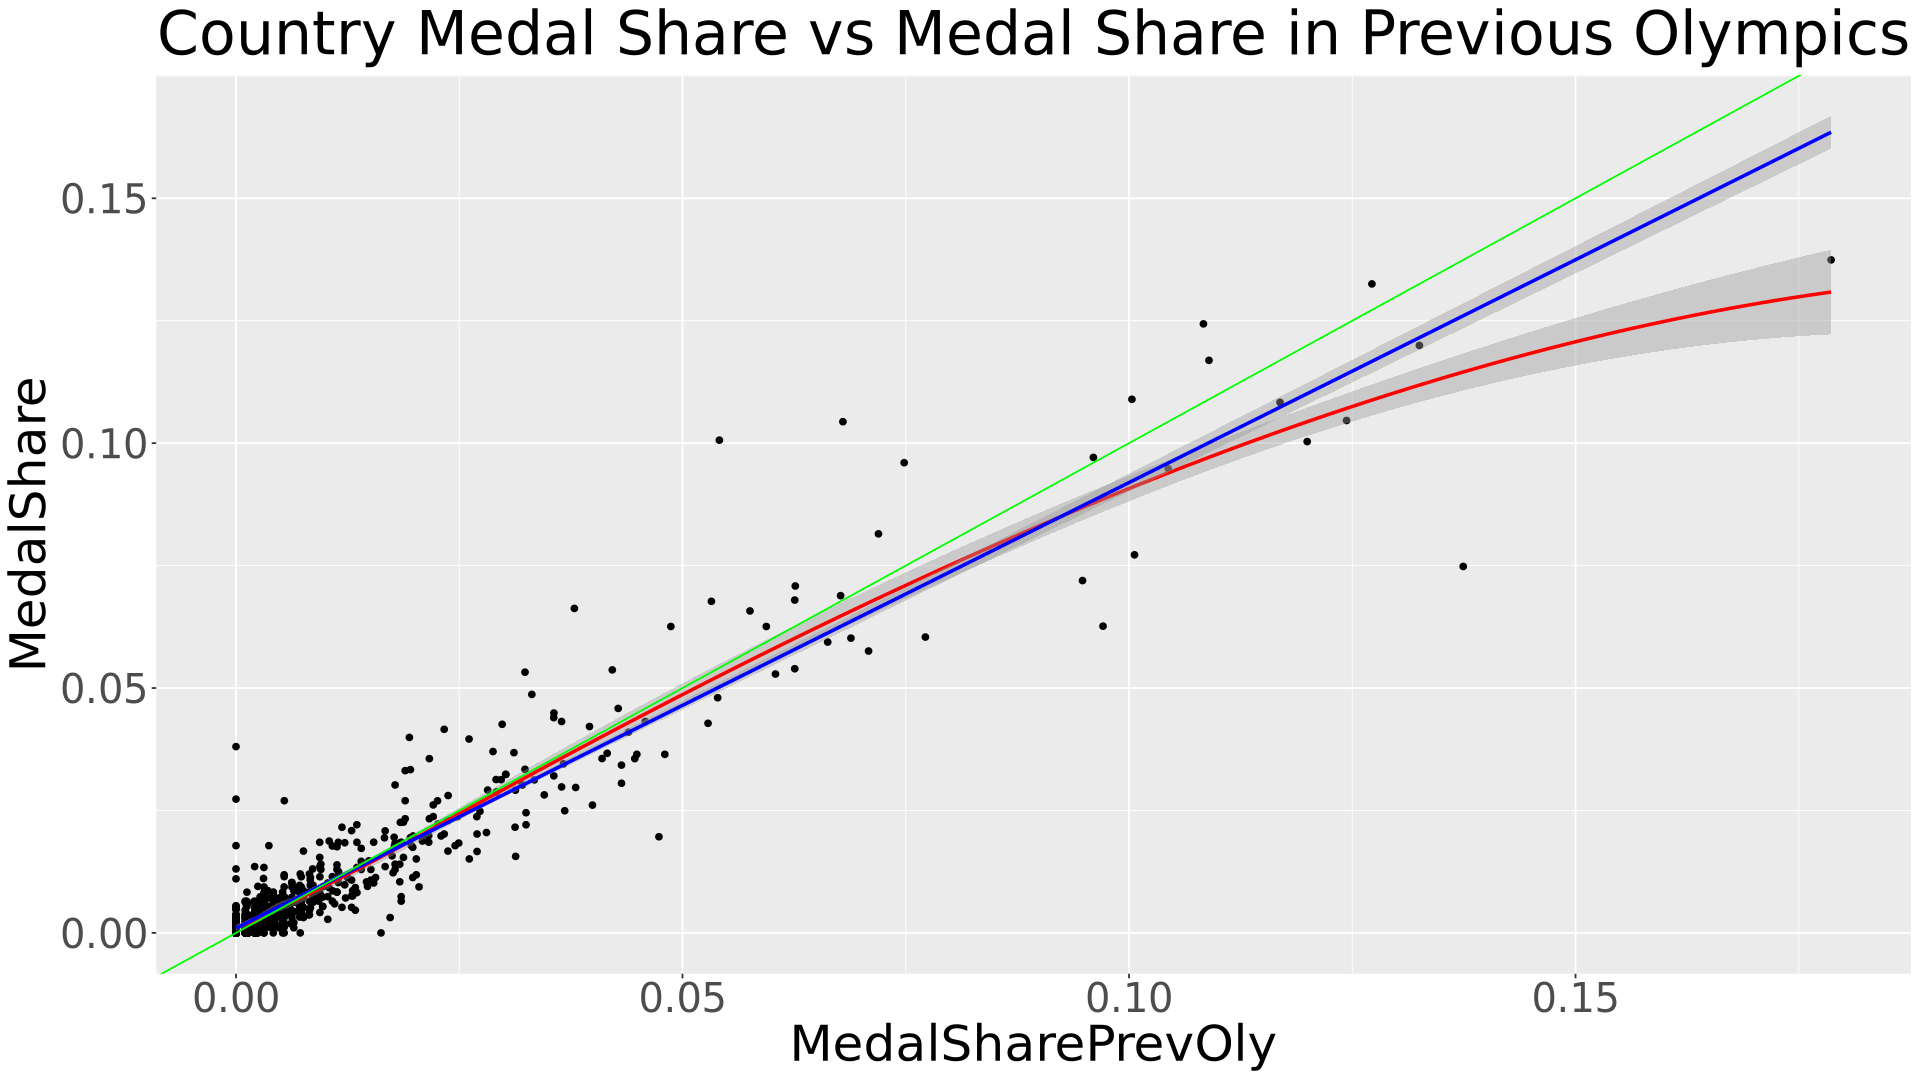

In [26]:
# Plot of medal share vs prev Olympics medal share
ggplot(
  data = country_year_medals_for_analysis,
  aes(x = MedalSharePrevOly, y = MedalShare)
  ) +
  geom_point() +
  geom_smooth(method = "loess", col = "red") +
  geom_smooth(method = "lm", col = "blue") +
  geom_abline(intercept = 0, slope = 1, col = "green") +
  labs(title = "Country Medal Share vs Medal Share in Previous Olympics")

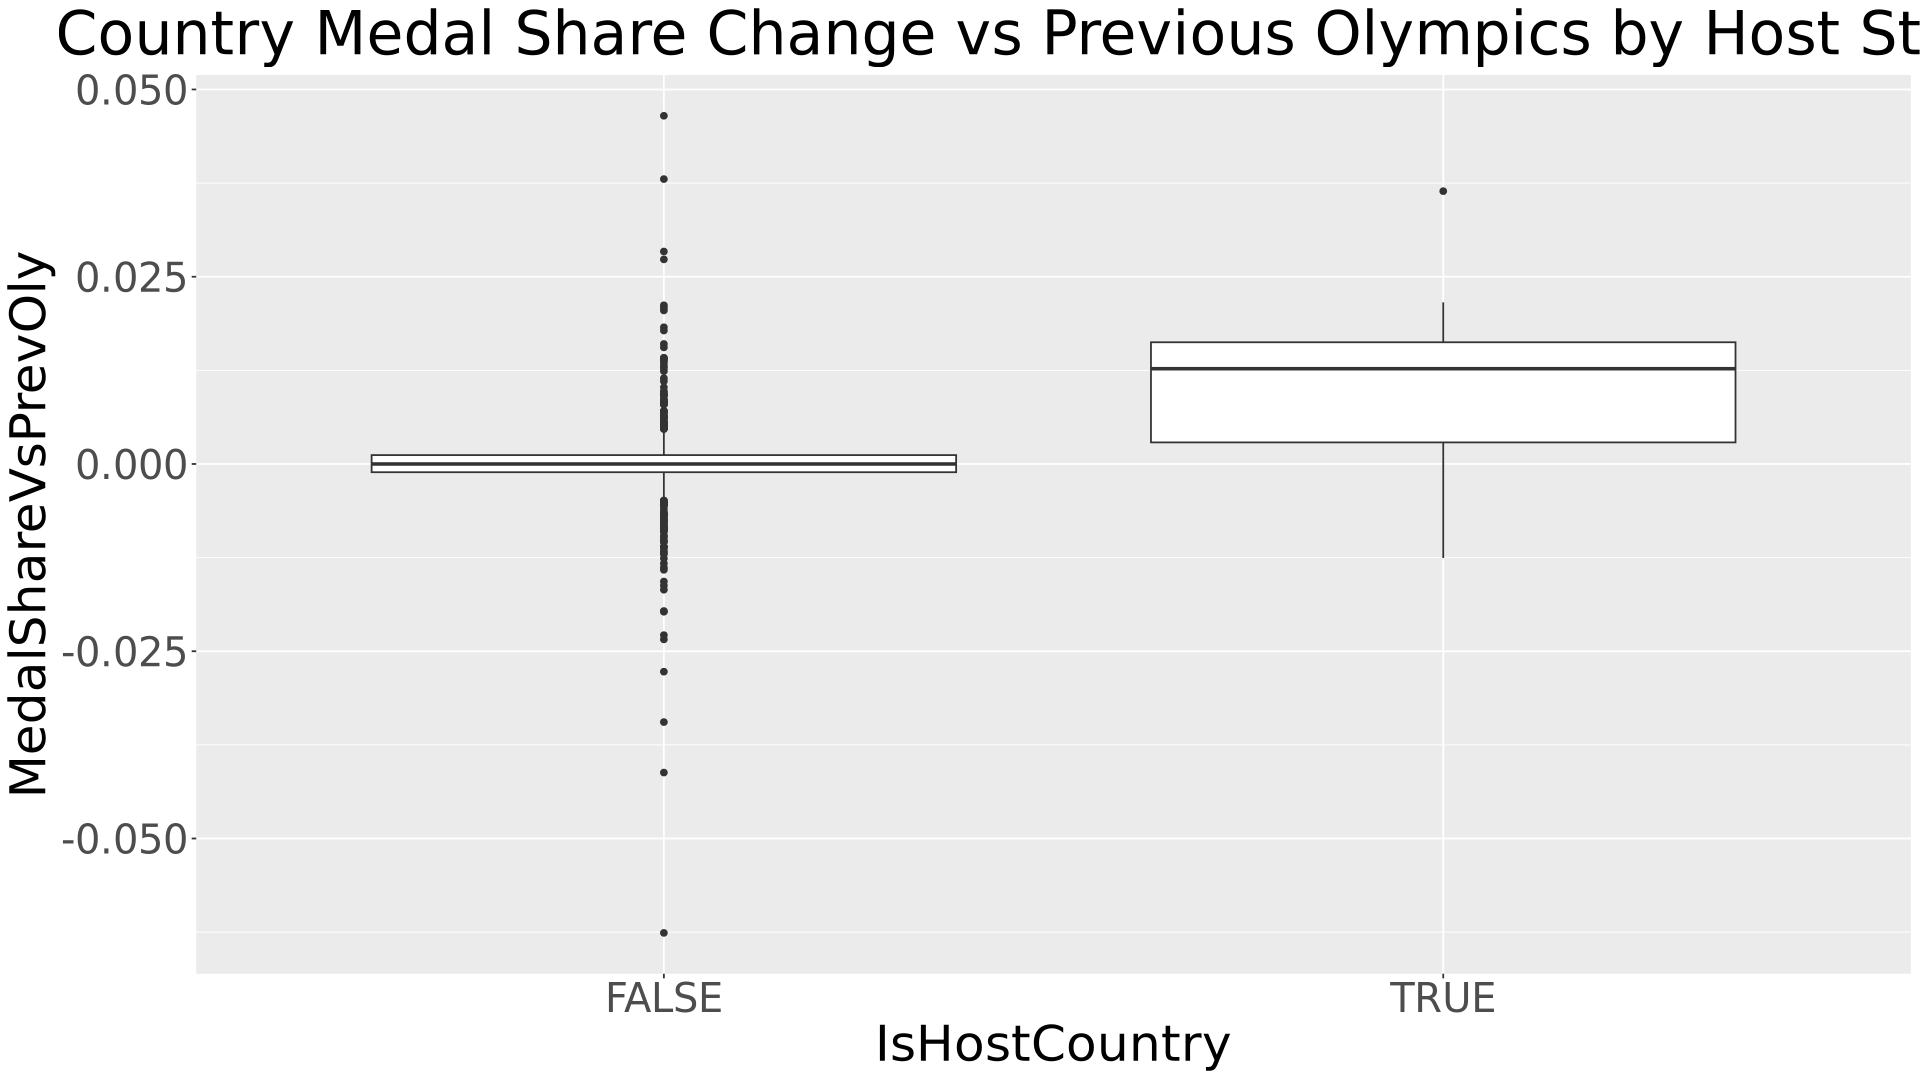

In [27]:
# Plot of medal share vs prev Olympics medal share by host country status
country_year_medals_for_analysis %>%
  mutate(
    MedalShareVsPrevOly = MedalShare - MedalSharePrevOly
    ) %>%
  ggplot(aes(x = IsHostCountry, y = MedalShareVsPrevOly)) +
    geom_boxplot() +
    labs(title = "Country Medal Share Change vs Previous Olympics by Host Status")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


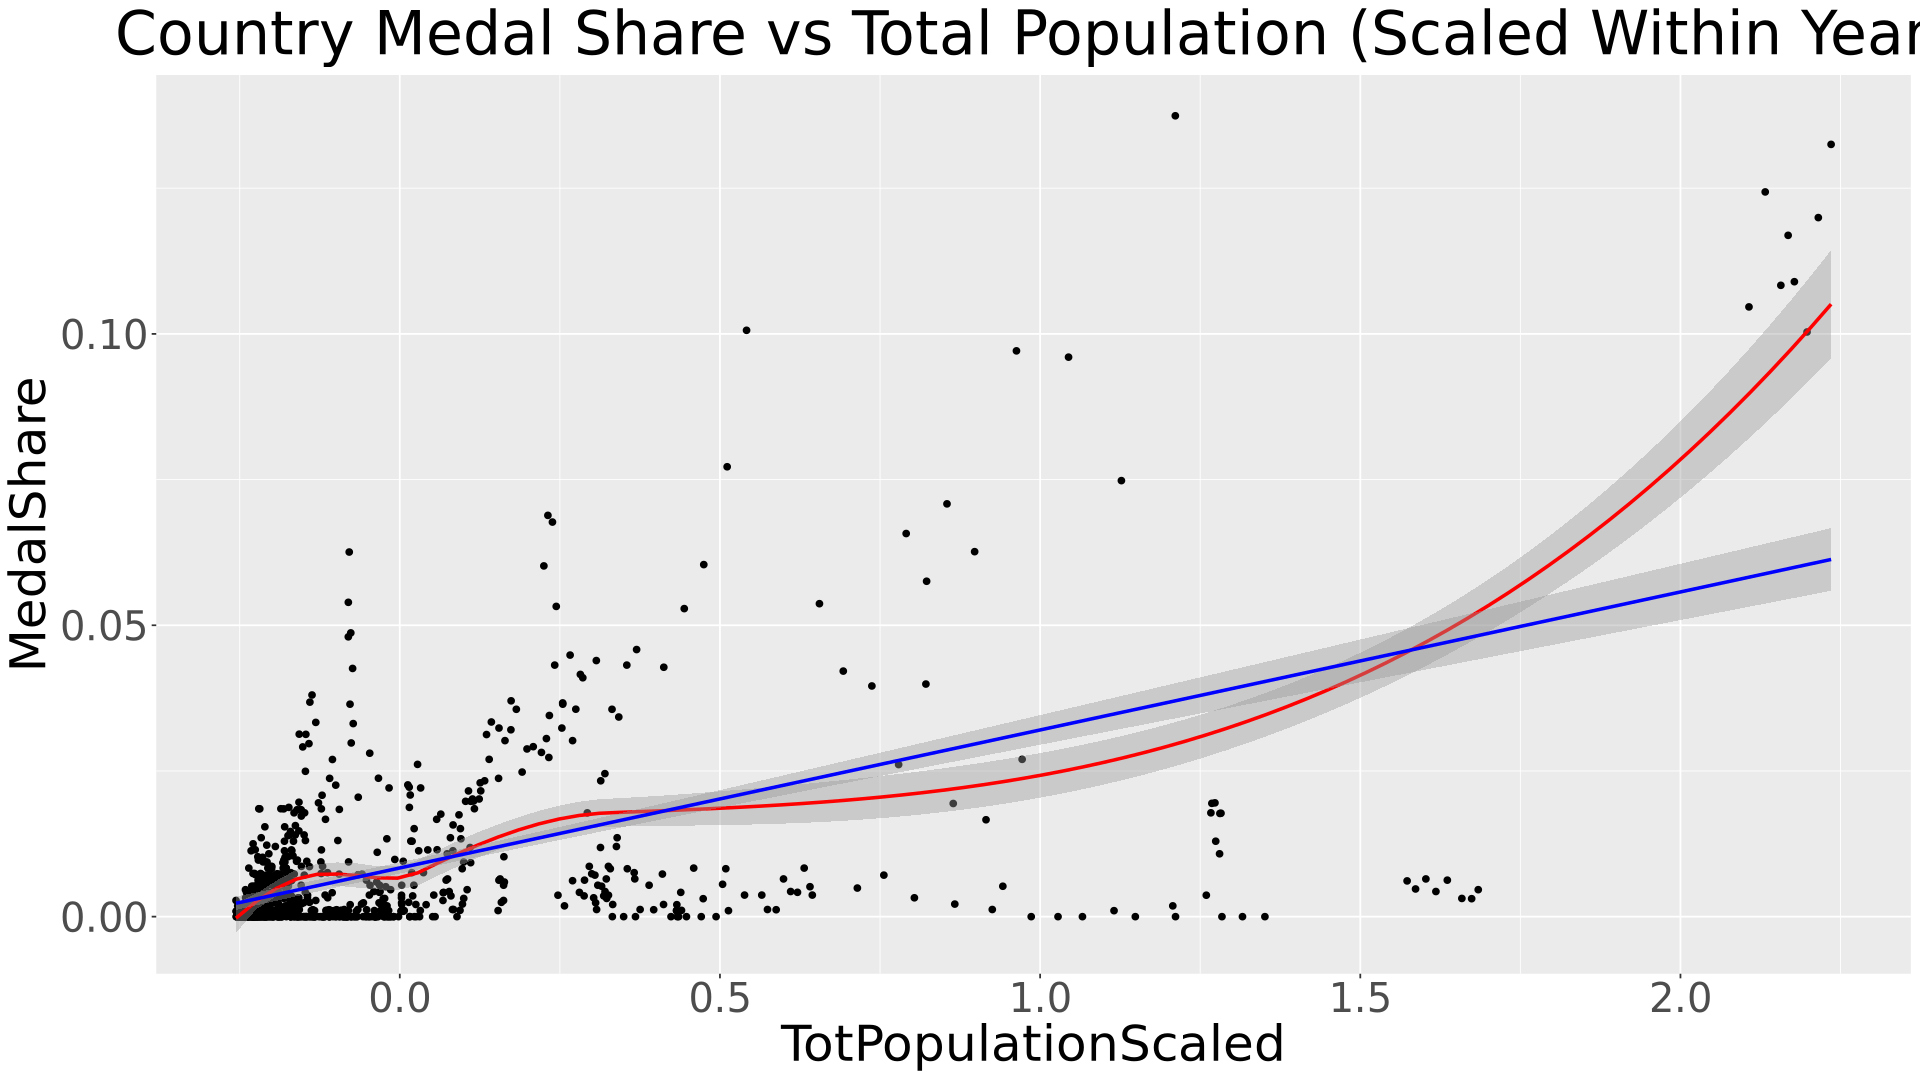

In [28]:
# Plot of medal share vs population (scaled)
ggplot(
  data = country_year_medals_for_analysis %>%
    # filter out outlier values (basically India and China)
    filter(abs(TotPopulationScaled) <= 4),
  aes(x = TotPopulationScaled, y = MedalShare)) +
  geom_point() +
  geom_smooth(method = "loess", col = "red") +
  geom_smooth(method = "lm", col = "blue") +
  labs(title = "Country Medal Share vs Total Population (Scaled Within Year)")

In [29]:
# Simple GLM across all data to see value of various factors
country_sharetotmedals_glm <- glm(
  MedalShare ~
    IsHostCountry + 
    MedalSharePrevOly +  
    MedalShare2OlyAgo +
    TotPopulationScaled +
    GDPCurrentUSDScaled +
    1
  , 
  data = country_year_medals_for_analysis, 
  family = "gaussian"
  )

summary(country_sharetotmedals_glm)


Call:
glm(formula = MedalShare ~ IsHostCountry + MedalSharePrevOly + 
    MedalShare2OlyAgo + TotPopulationScaled + GDPCurrentUSDScaled + 
    1, family = "gaussian", data = country_year_medals_for_analysis)

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.0012599  0.0002015   6.252 6.41e-10 ***
IsHostCountryTRUE   0.0150564  0.0018572   8.107 1.81e-15 ***
MedalSharePrevOly   0.7155852  0.0195807  36.545  < 2e-16 ***
MedalShare2OlyAgo   0.1096423  0.0181925   6.027 2.49e-09 ***
TotPopulationScaled 0.0005672  0.0001399   4.054 5.50e-05 ***
GDPCurrentUSDScaled 0.0012242  0.0001996   6.133 1.32e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.612674e-05)

    Null deviance: 0.289476  on 851  degrees of freedom
Residual deviance: 0.022103  on 846  degrees of freedom
  (33 observations deleted due to missingness)
AIC: -6564.9

Number of Fisher Scoring iterati

# Creating XGBoost Model of Country Olympic Medal Share

In [30]:
# Prep country Olympic medal share data for modeling

# Pick years for training, testing, and prediction
START_YEAR_FOR_TRAINING <- 1992

START_YEAR_FOR_TESTING <- 2016

YEAR_FOR_PREDICTION <- 2024

# Total # of medals in year for prediction to use to convert share to actual medals
# Per Wiki page for 2024 Olympics (https://en.wikipedia.org/wiki/2024_Summer_Olympics),
# 329 events * 3 medals/event (roughly) - ended up being more (1044 total, likely due
# to various ties for silver/bronze), but only knew that after the fact 
YEAR_FOR_PREDICTION_TOT_MEDALS <- 329*3

country_medal_share_model_data <- country_year_medals_info %>%
  filter(
    Year >= START_YEAR_FOR_TRAINING,
    Year <= YEAR_FOR_PREDICTION
    ) %>%
  mutate(
    # After filtering above, lags for missing medal shares should be actual 0s (not missing)
    across(c(MedalSharePrevOly, MedalShare2OlyAgo),
      ~ifelse(is.na(.x), 0, .x)),
    # Putting in total medal # for year for prediction (if missing)
    YrTotMedals = ifelse(is.na(YrTotMedals) & (Year == YEAR_FOR_PREDICTION), 
      YEAR_FOR_PREDICTION_TOT_MEDALS, YrTotMedals),
    # Create training/testing/prediction split based on Olympic years
    TrainTestPredSplit = case_when(
      (Year >= START_YEAR_FOR_TRAINING & Year < START_YEAR_FOR_TESTING) ~ "Train",
      (Year >= START_YEAR_FOR_TESTING & Year < YEAR_FOR_PREDICTION) ~ "Test",
      Year == YEAR_FOR_PREDICTION ~ "Prediction",
      TRUE ~ NA_character_
      ) %>% 
      factor(levels = c("Train", "Test", "Prediction"))
    ) %>%
  print()

# A tibble: 1,091 × 26
    Year Country   OlympicsCountryCode OlympicsCountryGroup IsHostCountry  Gold
   <int> <chr>     <chr>               <chr>                <lgl>         <int>
 1  1992 Algeria   ALG                 ALG                  FALSE             1
 2  1992 Argentina ARG                 ARG                  FALSE             0
 3  1992 Australia AUS                 AUS                  FALSE             7
 4  1992 Austria   AUT                 AUT                  FALSE             0
 5  1992 Bahamas   BAH                 BAH                  FALSE             0
 6  1992 Belgium   BEL                 BEL                  FALSE             0
 7  1992 Brazil    BRA                 BRA                  FALSE             2
 8  1992 Bulgaria  BUL                 BUL                  FALSE             3
 9  1992 Canada    CAN                 CAN                  FALSE             7
10  1992 Chile     CHI                 CHI                  FALSE             0
   Silver Bronze 

In [31]:
# Split data into training, testing, and prediction
country_medal_share_train_data <- country_medal_share_model_data %>%
  filter(TrainTestPredSplit == "Train")

country_medal_share_test_data <- country_medal_share_model_data %>%
  filter(TrainTestPredSplit == "Test")

country_medal_share_pred_data <- country_medal_share_model_data %>%
  filter(TrainTestPredSplit == "Prediction")

In [32]:
# Use Tidymodels to set up XGBoost model for country share of total medals
medal_share_recipe <- country_medal_share_model_data %>%
  recipe(MedalShare ~
    IsHostCountry + 
    MedalSharePrevOly +  
    MedalShare2OlyAgo +
    TotPopulationScaled +
    GDPCurrentUSDScaled
    ) %>%
  step_integer(c("IsHostCountry"))

country_medal_share_prep <- bake(
  prep(medal_share_recipe), 
  has_role("predictor"),
  new_data = country_medal_share_model_data,
  composition = "matrix"
  )

xgboost_model <- boost_tree(
  mode = "regression",
  trees = 200,
  tree_depth = 5,
  learn_rate = 0.05,
  engine = "xgboost"
)

In [33]:
# Create workflow, fit model, and get eval metrics on test set
medal_share_wf <- workflow() %>%
  add_recipe(medal_share_recipe) %>%
  add_model(xgboost_model)

# Fit model on training set
medal_share_fit <- medal_share_wf %>% fit(country_medal_share_train_data)

# Create set of evaluation metrics of interest
medal_share_eval_metrics <- metric_set(rmse, mae, rsq)

# Evaluate fit of model predictions (Olympic medal share) on test set
augment(medal_share_fit, new_data = country_medal_share_test_data) %>% 
  # Evaluate the metric set
  medal_share_eval_metrics(truth = MedalShare, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.004205362
mae,standard,0.002527494
rsq,standard,0.934778796


In [34]:
# Add model predictions (share and medals) to all data (training, test, pred)
country_medal_share_model_results <- country_medal_share_model_data %>%
  mutate(
    PredMedalShare = predict(
      object = medal_share_fit, 
      new_data = country_medal_share_model_data
      ) %>% pluck(".pred"),
    ) %>%
  group_by(Year) %>%
  mutate(
    # Get total predicted share of medals by year - should be close to 1
    # for each year, but not constrained to be
    YrTotPredMedalShare = sum(PredMedalShare)
    ) %>%
  ungroup() %>%
  mutate(
    # Normalize so that predicted medal share/totals add up to desired values
    NormPredMedalShare = PredMedalShare / YrTotPredMedalShare,
    PredMedals = NormPredMedalShare * YrTotMedals
    ) %>%
  group_by(Year) %>%
  mutate(
    # Get rank and # tied at rank (by year) for predicted medals
    PredMedalsRk = rank(desc(PredMedals), ties.method = "min", na.last = "keep"),
    PredMedalsRkNumAtRk = rank(desc(PredMedals), ties.method = "max", na.last = "keep") -
      PredMedalsRk + 1L
    ) %>%
  ungroup() %>%
  mutate(
    PredMedalsText = glue("{Year} {Country}\n", 
      "Predicted Medal Share: {sprintf('%.2f%%', PredMedalShare * 100)}\n",
      "Predicted Medals: {sprintf('%.1f', PredMedals)}\n",
      "Predicted Medals Rank: {PredMedalsRk}",
      "{ifelse(PredMedalsRkNumAtRk > 1, paste0(' (', PredMedalsRkNumAtRk, ' tied)'), '')}\n"
      ) %>%
      as.character()      
    ) %>%  
  print()

# A tibble: 1,091 × 33
    Year Country   OlympicsCountryCode OlympicsCountryGroup IsHostCountry  Gold
   <int> <chr>     <chr>               <chr>                <lgl>         <int>
 1  1992 Algeria   ALG                 ALG                  FALSE             1
 2  1992 Argentina ARG                 ARG                  FALSE             0
 3  1992 Australia AUS                 AUS                  FALSE             7
 4  1992 Austria   AUT                 AUT                  FALSE             0
 5  1992 Bahamas   BAH                 BAH                  FALSE             0
 6  1992 Belgium   BEL                 BEL                  FALSE             0
 7  1992 Brazil    BRA                 BRA                  FALSE             2
 8  1992 Bulgaria  BUL                 BUL                  FALSE             3
 9  1992 Canada    CAN                 CAN                  FALSE             7
10  1992 Chile     CHI                 CHI                  FALSE             0
   Silver Bronze 

In [35]:
# Evaluate fit of model predicted Olympic medals (actual #, not share) on test set
medal_share_eval_metrics(
  country_medal_share_model_results %>% 
    filter(TrainTestPredSplit == "Test"), 
  truth = Medals, 
  estimate = PredMedals
  ) %>%
  print()

# A tibble: 3 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard       4.15 
2 mae     standard       2.44 
3 rsq     standard       0.936


# A tibble: 5 × 2
  Variable            Importance
  <chr>                    <dbl>
1 MedalSharePrevOly      0.746  
2 GDPCurrentUSDScaled    0.131  
3 TotPopulationScaled    0.0722 
4 MedalShare2OlyAgo      0.0457 
5 IsHostCountry          0.00516


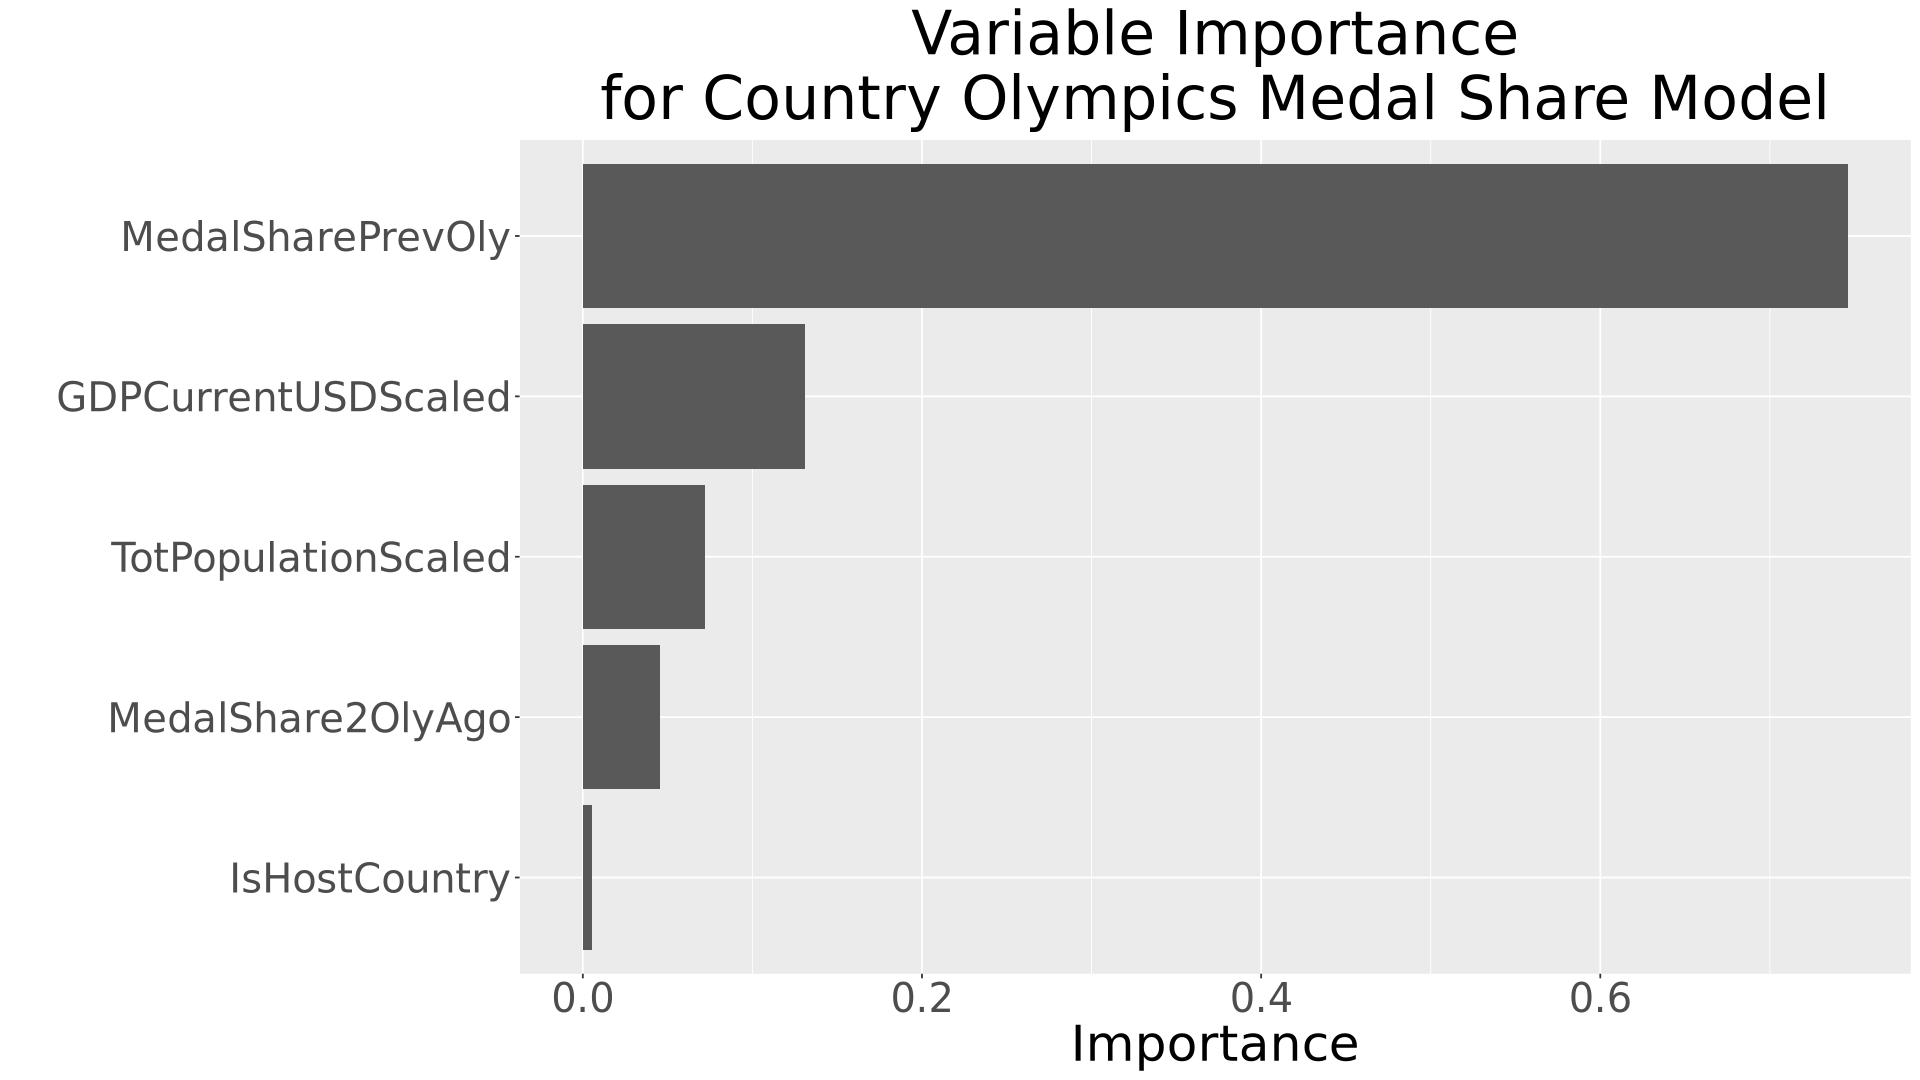

In [36]:
# Get global variable importance for model
medal_share_model_var_imp <- vip::vi(medal_share_fit) %>%
  print()

(
medal_share_model_var_imp_plot <- vip::vip(medal_share_fit) +
  labs(
    title = "Variable Importance\nfor Country Olympics Medal Share Model"
    )
)

`geom_smooth()` using formula = 'y ~ x'


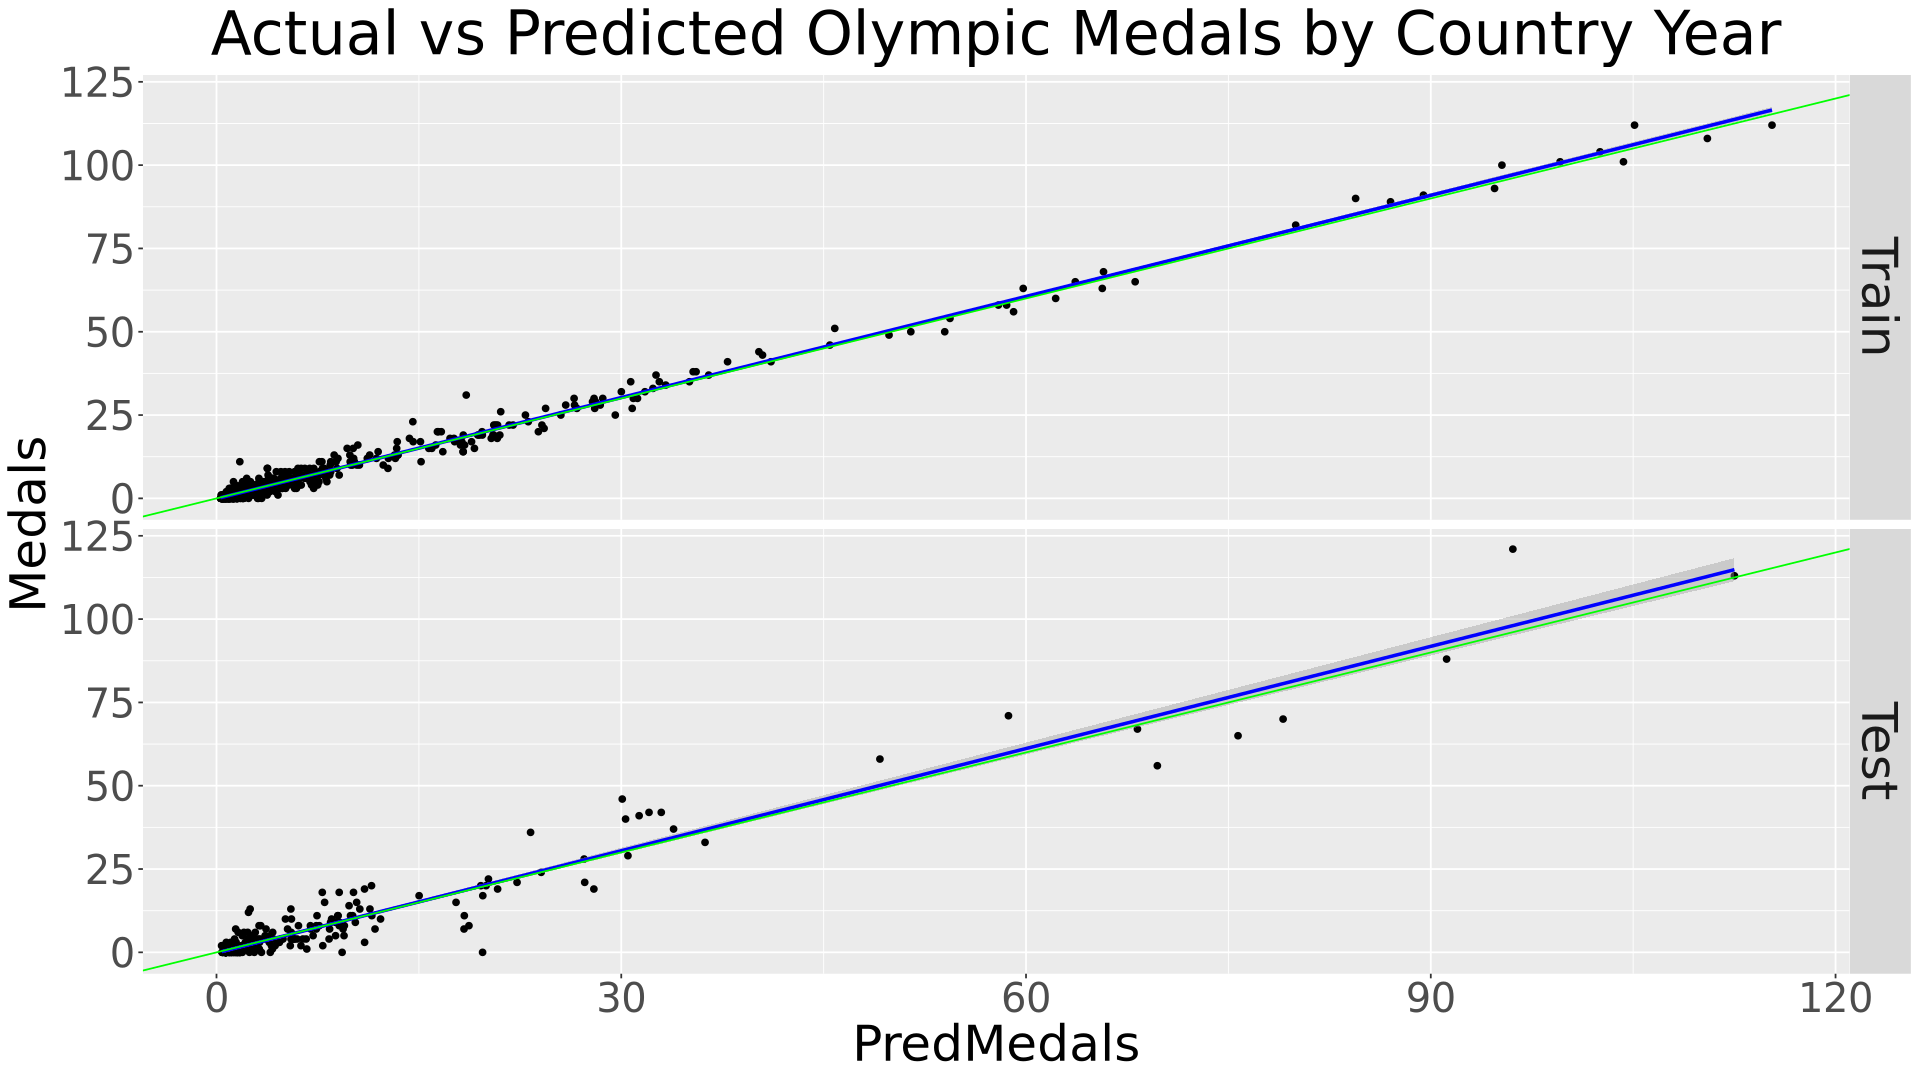

In [37]:
# Plot of actual vs predicted medals by country, faceted by training/test split
ggplot(
  data = country_medal_share_model_results %>%
    filter(TrainTestPredSplit != "Prediction"),
  aes(x = PredMedals, y = Medals)
  ) +
  geom_point() +
  facet_grid(TrainTestPredSplit ~ .) +
  geom_smooth(method = "lm", col = "blue") +
  geom_abline(intercept = 0, slope = 1, col = "green") +
  labs(title = "Actual vs Predicted Olympic Medals by Country Year")

# Get Shapley Values and Related Plots from XGBoost Model

In [38]:
# Get XGBoost model shap values for each observation (1 row per variable per observation)
country_medal_share_model_shap_values <- shap.prep(
  xgb_model = extract_fit_engine(medal_share_fit),
  X_train = country_medal_share_prep
  ) %>%
  print()

        ID          variable         value    rfvalue   stdfvalue   mean_value
   1:    1 MedalSharePrevOly -6.410438e-03 0.00000000 0.000000000 0.0080946229
   2:    2 MedalSharePrevOly -4.975820e-03 0.00270636 0.015151515 0.0080946229
   3:    3 MedalSharePrevOly  1.101159e-02 0.01894452 0.106060606 0.0080946229
   4:    4 MedalSharePrevOly -6.536255e-03 0.00135318 0.007575758 0.0080946229
   5:    5 MedalSharePrevOly -6.540603e-03 0.00000000 0.000000000 0.0080946229
  ---                                                                         
5451: 1087     IsHostCountry -4.559548e-05 1.00000000 0.000000000 0.0001368925
5452: 1088     IsHostCountry -4.334044e-05 1.00000000 0.000000000 0.0001368925
5453: 1089     IsHostCountry -4.665821e-05 1.00000000 0.000000000 0.0001368925
5454: 1090     IsHostCountry -4.480832e-05 1.00000000 0.000000000 0.0001368925
5455: 1091     IsHostCountry -4.384124e-05 1.00000000 0.000000000 0.0001368925


In [39]:
# Add individual observation shap values back to original tibble
# Get model Shapley values for each ID (country year) in wide format
country_medal_share_model_shap_values_wide <- country_medal_share_model_shap_values %>%
  pivot_wider(
    id_cols = c(ID), 
    names_from = c(variable), 
    values_from = c(value),
    names_prefix = "ShapValue"
    )

# Aggregate all Shapley values for each country year into text to be used in Gemini prompt
country_medal_share_model_shap_values_text <- country_medal_share_model_shap_values %>% 
  as_tibble() %>%
  select(ID, Predictor = variable, ShapValue = value) %>%
  group_by(ID) %>%
  summarize(
    PredictorShapValuesText = paste0(glue("{Predictor} Shap Value: {ShapValue}"), collapse = "\n")
    ) %>%
  ungroup()

country_medal_share_model_shap <- country_medal_share_model_results %>%
  mutate(
    # Need to add ID # to join in shapley values indexed by that
    ID = row_number()
    ) %>%
  left_join(
    country_medal_share_model_shap_values_wide,
    by = c("ID")
    ) %>%
  left_join(
    country_medal_share_model_shap_values_text,
    by = c("ID")
    ) %>%
  print()

# A tibble: 1,091 × 40
    Year Country   OlympicsCountryCode OlympicsCountryGroup IsHostCountry  Gold
   <int> <chr>     <chr>               <chr>                <lgl>         <int>
 1  1992 Algeria   ALG                 ALG                  FALSE             1
 2  1992 Argentina ARG                 ARG                  FALSE             0
 3  1992 Australia AUS                 AUS                  FALSE             7
 4  1992 Austria   AUT                 AUT                  FALSE             0
 5  1992 Bahamas   BAH                 BAH                  FALSE             0
 6  1992 Belgium   BEL                 BEL                  FALSE             0
 7  1992 Brazil    BRA                 BRA                  FALSE             2
 8  1992 Bulgaria  BUL                 BUL                  FALSE             3
 9  1992 Canada    CAN                 CAN                  FALSE             7
10  1992 Chile     CHI                 CHI                  FALSE             0
   Silver Bronze 

In [40]:
# Extract various Shapley visualizations from model, inspired by walkthrough in
# this post: https://www.r-bloggers.com/2023/01/shap-xgboost-tidymodels-love/
country_medal_share_model_shap_visuals <- shapviz(
  extract_fit_engine(medal_share_fit),
  X_pred = country_medal_share_prep,
  X = country_medal_share_model_data
  )

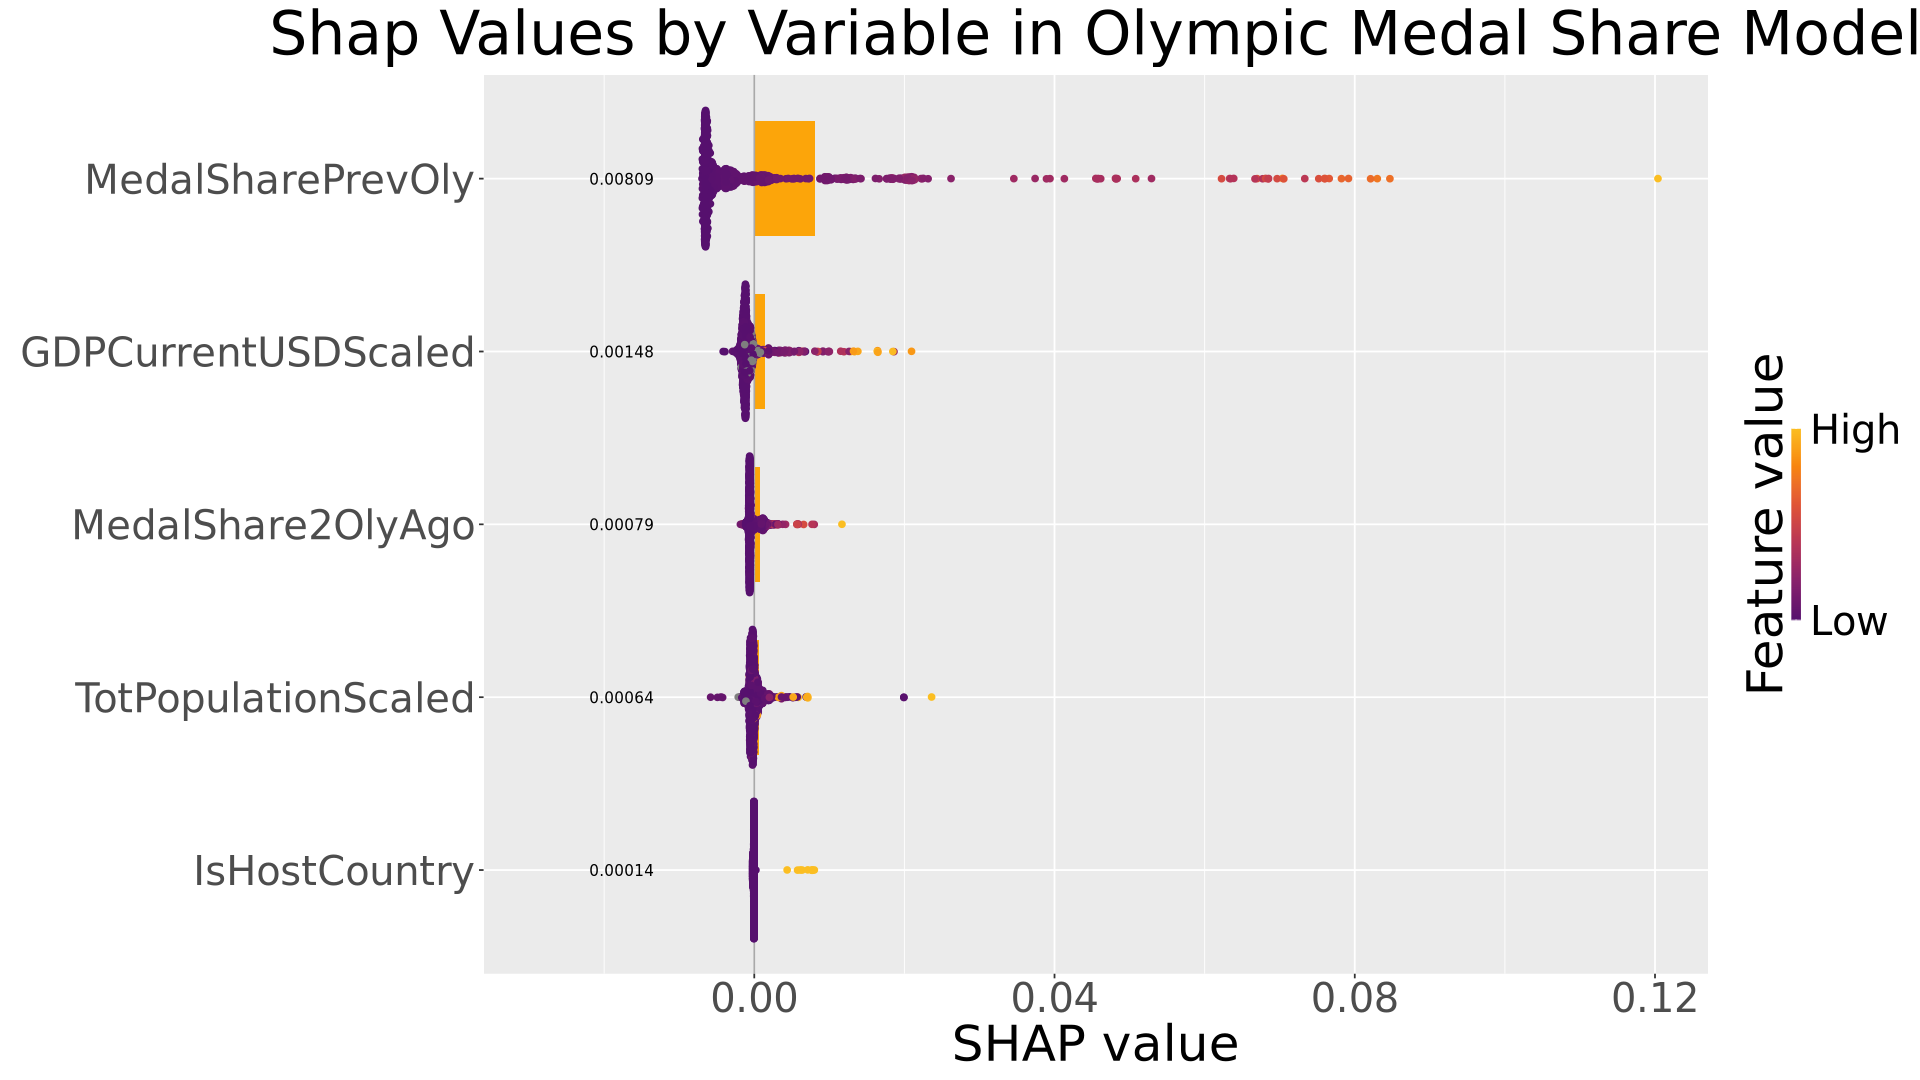

In [41]:
# Plot of all Shapley values by variable from medal share model
(
country_medal_share_model_overall_shap_plot <- sv_importance(
  country_medal_share_model_shap_visuals, kind = "both", show_numbers = TRUE) +
  labs(title = "Shap Values by Variable in Olympic Medal Share Model") +
  theme_update(default_plot_theme)
)

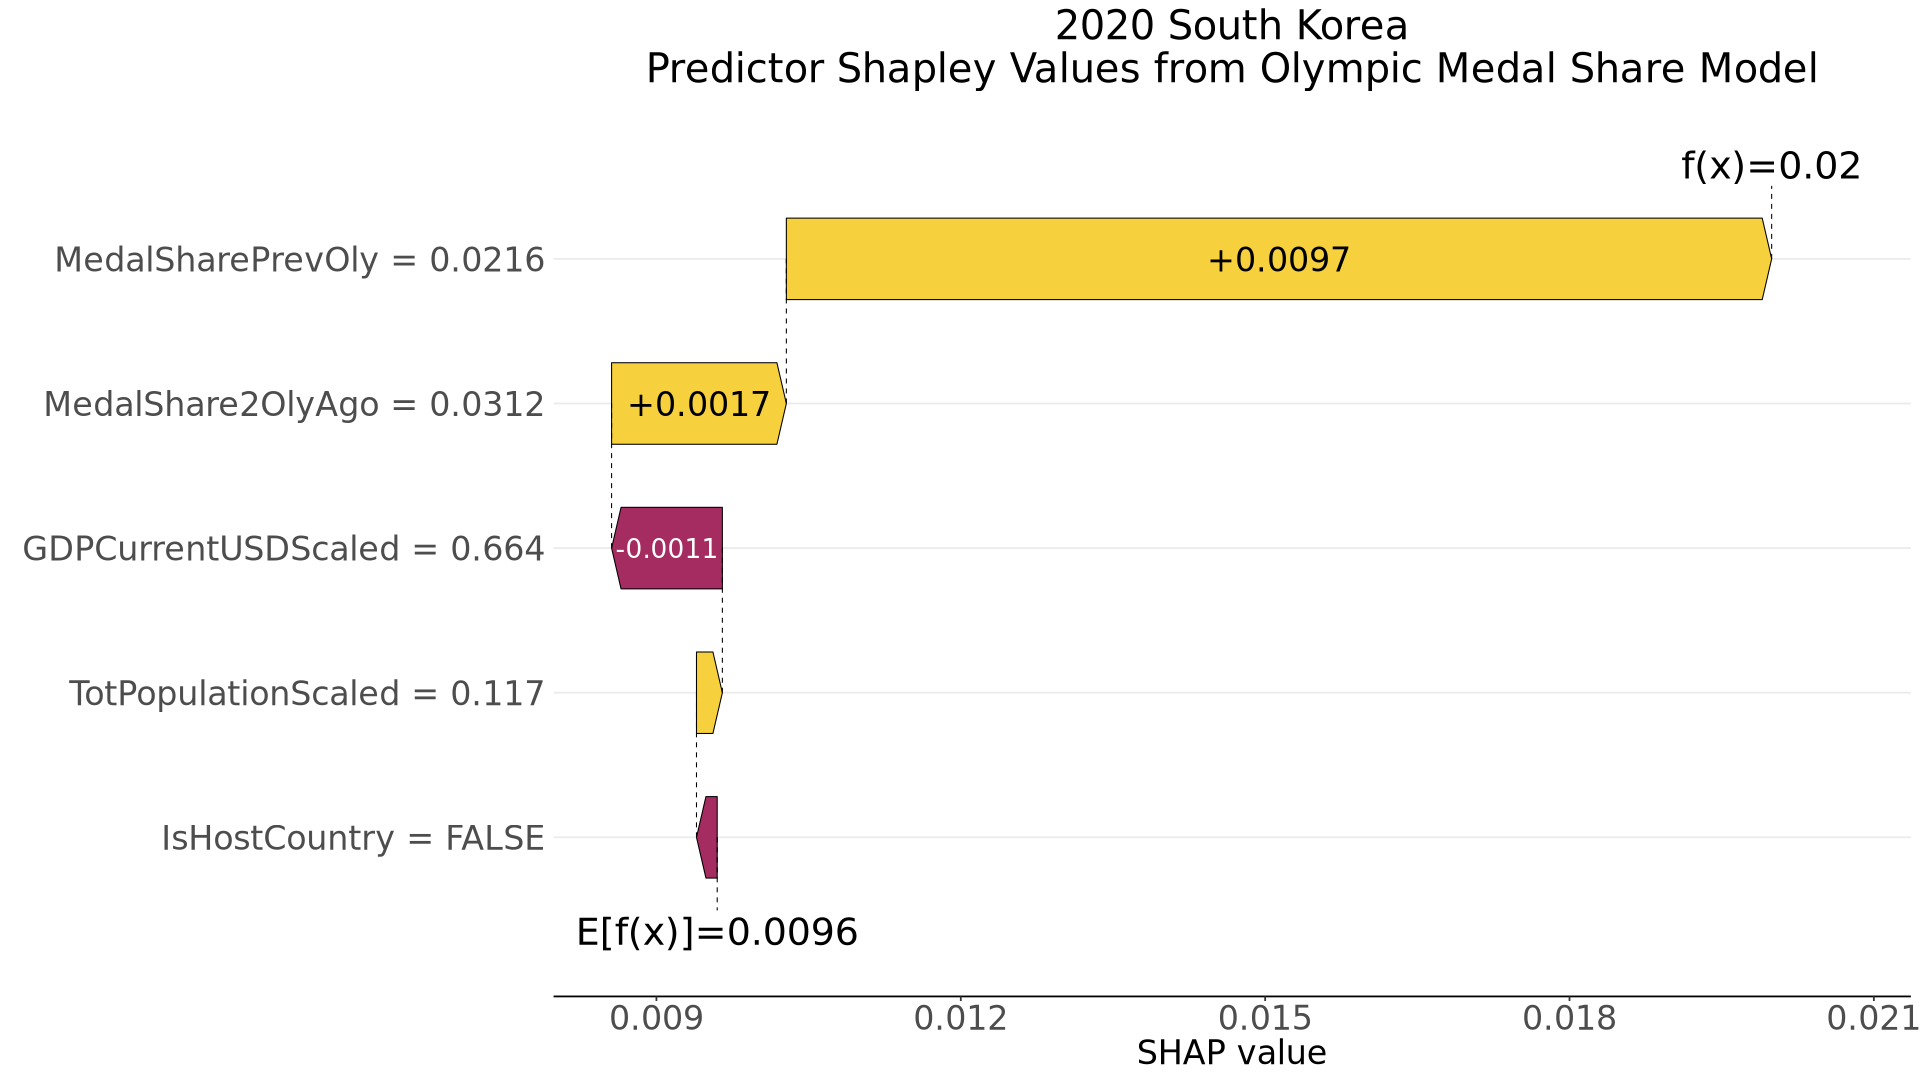

In [42]:
# Function to get Shapley value waterfall plot for any single row (country year)
GetCountryMedalShareModelPredShapWaterfallPlot <- function(ID, year, country)
{
  pred_shap_waterfall_plot_title <- glue("{year} {country}\nPredictor Shapley Values ",
    "from Olympic Medal Share Model") %>% as.character()
    
  pred_shap_waterfall_plot <- sv_waterfall(
    object = country_medal_share_model_shap_visuals,
    row_id = ID,
    size = 20,
    annotation_size = 8,
    format_shap = function(x) round(x, digits = 4),
    ) +
    labs(title = pred_shap_waterfall_plot_title) + 
    theme(
      plot.title = element_text(size = 24, hjust = 0.5),
      axis.title = element_text(size = 20),
      axis.text = element_text(size = 20),
      )
    
  return(pred_shap_waterfall_plot)
}

# Get example plot for 1 random country/year
with(sample_n(country_medal_share_model_shap, 1) %>% as.list(),
  GetCountryMedalShareModelPredShapWaterfallPlot(ID, Year, Country)
  )

In [43]:
# Create predictor shap values plot for each country year in prediction dataset
plan(multisession)

tic("Creating Shapley Values Plots for Each Country Year")

pred_year_country_medal_share_model_plots <- country_medal_share_model_shap %>%
  filter(TrainTestPredSplit == "Prediction") %>%
  mutate(
    PredictorShapValuesPlot = future_pmap(list(ID, Year, Country), 
      GetCountryMedalShareModelPredShapWaterfallPlot),
    PredictorShapValuesPlotFileName = glue("{Year}_{str_replace_all(Country, ' ', '_')}_",
      "olympic_medal_share_model_pred_shap_values_plot.png") %>% as.character()
    ) %>%
  print()

toc()

# A tibble: 206 × 42
    Year Country                     OlympicsCountryCode OlympicsCountryGroup
   <int> <chr>                       <chr>               <chr>               
 1  2024 Afghanistan                 AFG                 AFG                 
 2  2024 Individual Neutral Athletes AIN                 AIN                 
 3  2024 Albania                     ALB                 ALB                 
 4  2024 Algeria                     ALG                 ALG                 
 5  2024 Andorra                     AND                 AND                 
 6  2024 Angola                      ANG                 ANG                 
 7  2024 Antigua and Barbuda         ANT                 ANT                 
 8  2024 Argentina                   ARG                 ARG                 
 9  2024 Armenia                     ARM                 ARM                 
10  2024 Aruba                       ARU                 ARU                 
   IsHostCountry  Gold Silver Bronze Medals

In [44]:
# Output all country year pred shap values plots to specified location in Cloud Storage
# plan(multisession)

tic("Outputting Shapley Values Plots for Each Country Year to Google Cloud Storage")

# Couldn't get multithreaded future_pwalk working as desired here, so sticking with pwalk
pwalk(
  with(pred_year_country_medal_share_model_plots, 
    list(
      plot_object = PredictorShapValuesPlot,
      file_name = PredictorShapValuesPlotFileName,
      bucket_name = BUCKET_NAME,
      bucket_subdir = glue("{BUCKET_SUBDIR}/country_medal_share_pred_shap_values_plots") %>%
        as.character(),
      project_id = PROJECT_ID,
      plot_scale = 1,
      check_output_dir_after_write = FALSE,
      delete_local_file = TRUE      
      )
    ),
    UploadGGPlotObjectToCloudStorageBucket
  )

toc()

Outputting Shapley Values Plots for Each Country Year to Google Cloud Storage: 945.033 sec elapsed


# Get Country Medal Share Model Prediction Explanations from Gemini

In [45]:
# Function to get model prediction explanations from Gemini
GetModelPredictionExplanationFromGemini <- function(year, country, is_host_country, pred_medals_text,
  predictor_shap_values_plot_gcs_uri, predictor_shap_values_text, language, print_prompt = FALSE)
{
  prediction_explanation_prompt <- glue(
    "You are a data scientist who does a great job of explaining various outputs from data analysis and ",
    "modeling, including numbers, tables, and plots, to help a more general audience understand your results ",
    "better.\n",
    "Please use the information below and the provided Shapley plot to explain {country}'s {year} Olympics medal ",
    "predictions from the medal prediction model.\n\n{pred_medals_text}\n\n",

    "To understand the predictors in the Shapley plot:\n",
    "- MedalSharePrevOly: country's medal share in the previous Summer Olympics\n",
    "- MedalShare2OlyAgo: country's medal share 2 Summer Olympics ago\n",
    "- TotPopulationScaled: country's population, standardized across all countries by year (average is 0)\n",
    "- GDPCurrentUSDScaled: country's GDP (standardized by year, average 0), a rough measure of its resources\n",
    "- IsHostCountry: TRUE/FALSE, if country hosted that year's Olympics \n\n",
    "Below are the actual Shapley values for each predictor:\n{predictor_shap_values_text}\n\n",
    "Put an emphasis on the predictors with larger magnitude Shapley values, noting general level and direction ",
    "of impact. Don't reference the Shapley values directly, just talk about the impact of predictors in a way ",
    "that a general audience would understand. No need to mention predictors with lower magnitude Shapley values in ",
    "your response. Don't use Shapley values to make conclusions that they do not support (e.g. don't compare ",
    "medal shares to previous years.\n",
    "{ifelse(is_host_country, 
      paste0('Make sure to mention the impact of ', country, ' hosting the Olympics.\n'),
      ''
      )}",
    "Refer to what predictors represent as opposed to their variable names in your explanation.\n\n",

    "Stick to only the data and information provided in creating your response. ",
    "Your response should be understandable by a non-technical audience, 100 words or fewer, and in {language}.\n"
    )

  if(print_prompt) {cat(prediction_explanation_prompt)}

  prediction_explanation_response <- GeminiFlashModel$generate_content(
    contents = list(
      Part$from_uri(
        predictor_shap_values_plot_gcs_uri,
        mime_type="image/png"
        ),
      prediction_explanation_prompt 
      ),
    generation_config = GenerationConfig(
      temperature = 0,
      max_output_tokens = 500L
      )  
    )
    
  prediction_explanation_response_text <- prediction_explanation_response$text
  
  return(prediction_explanation_response_text)
}

In [46]:
# Get explanations for all countries based on their data and Shapley plots, one by one
# plan(multisession)

tic("Getting Explanations for All Countries' Model Results Using Gemini")

# Couldn't get multithreaded future_pmap_chr working as desired here, so going with pmap_chr
pred_year_country_medal_share_model_explain <- pred_year_country_medal_share_model_plots %>%
  mutate(
    PredictorShapValuesPlotGCSURI = glue("gs://{BUCKET_NAME}/{BUCKET_SUBDIR}/",
      "country_medal_share_pred_shap_values_plots/{PredictorShapValuesPlotFileName}") %>% 
      as.character(),      
    PredictionExplanation = pmap_chr(
      list(
        year = Year, 
        country = Country,
        is_host_country = IsHostCountry,
        pred_medals_text = PredMedalsText, 
        predictor_shap_values_plot_gcs_uri = PredictorShapValuesPlotGCSURI,
        predictor_shap_values_text = PredictorShapValuesText,
        language = ifelse(is.na(GeminiSupportedLanguage), "English", GeminiSupportedLanguage)
        ),
      GetModelPredictionExplanationFromGemini
      )
    ) %>%
  print()

toc()

# A tibble: 206 × 44
    Year Country                     OlympicsCountryCode OlympicsCountryGroup
   <int> <chr>                       <chr>               <chr>               
 1  2024 Afghanistan                 AFG                 AFG                 
 2  2024 Individual Neutral Athletes AIN                 AIN                 
 3  2024 Albania                     ALB                 ALB                 
 4  2024 Algeria                     ALG                 ALG                 
 5  2024 Andorra                     AND                 AND                 
 6  2024 Angola                      ANG                 ANG                 
 7  2024 Antigua and Barbuda         ANT                 ANT                 
 8  2024 Argentina                   ARG                 ARG                 
 9  2024 Armenia                     ARM                 ARM                 
10  2024 Aruba                       ARU                 ARU                 
   IsHostCountry  Gold Silver Bronze Medals

2024 France
Predicted Medal Share: 4.20%
Predicted Medals: 40.3
Predicted Medals Rank: 5

Le modèle prédit que la France gagnera 4,20% des médailles aux Jeux olympiques de 2024, ce qui se traduirait par environ 40 médailles et la placerait au 5e rang. Le modèle prédit que la France gagnera plus de médailles que prévu en raison de son succès aux Jeux olympiques précédents. Le fait que la France accueillera les Jeux olympiques de 2024 a également un impact positif sur les prédictions du modèle. 




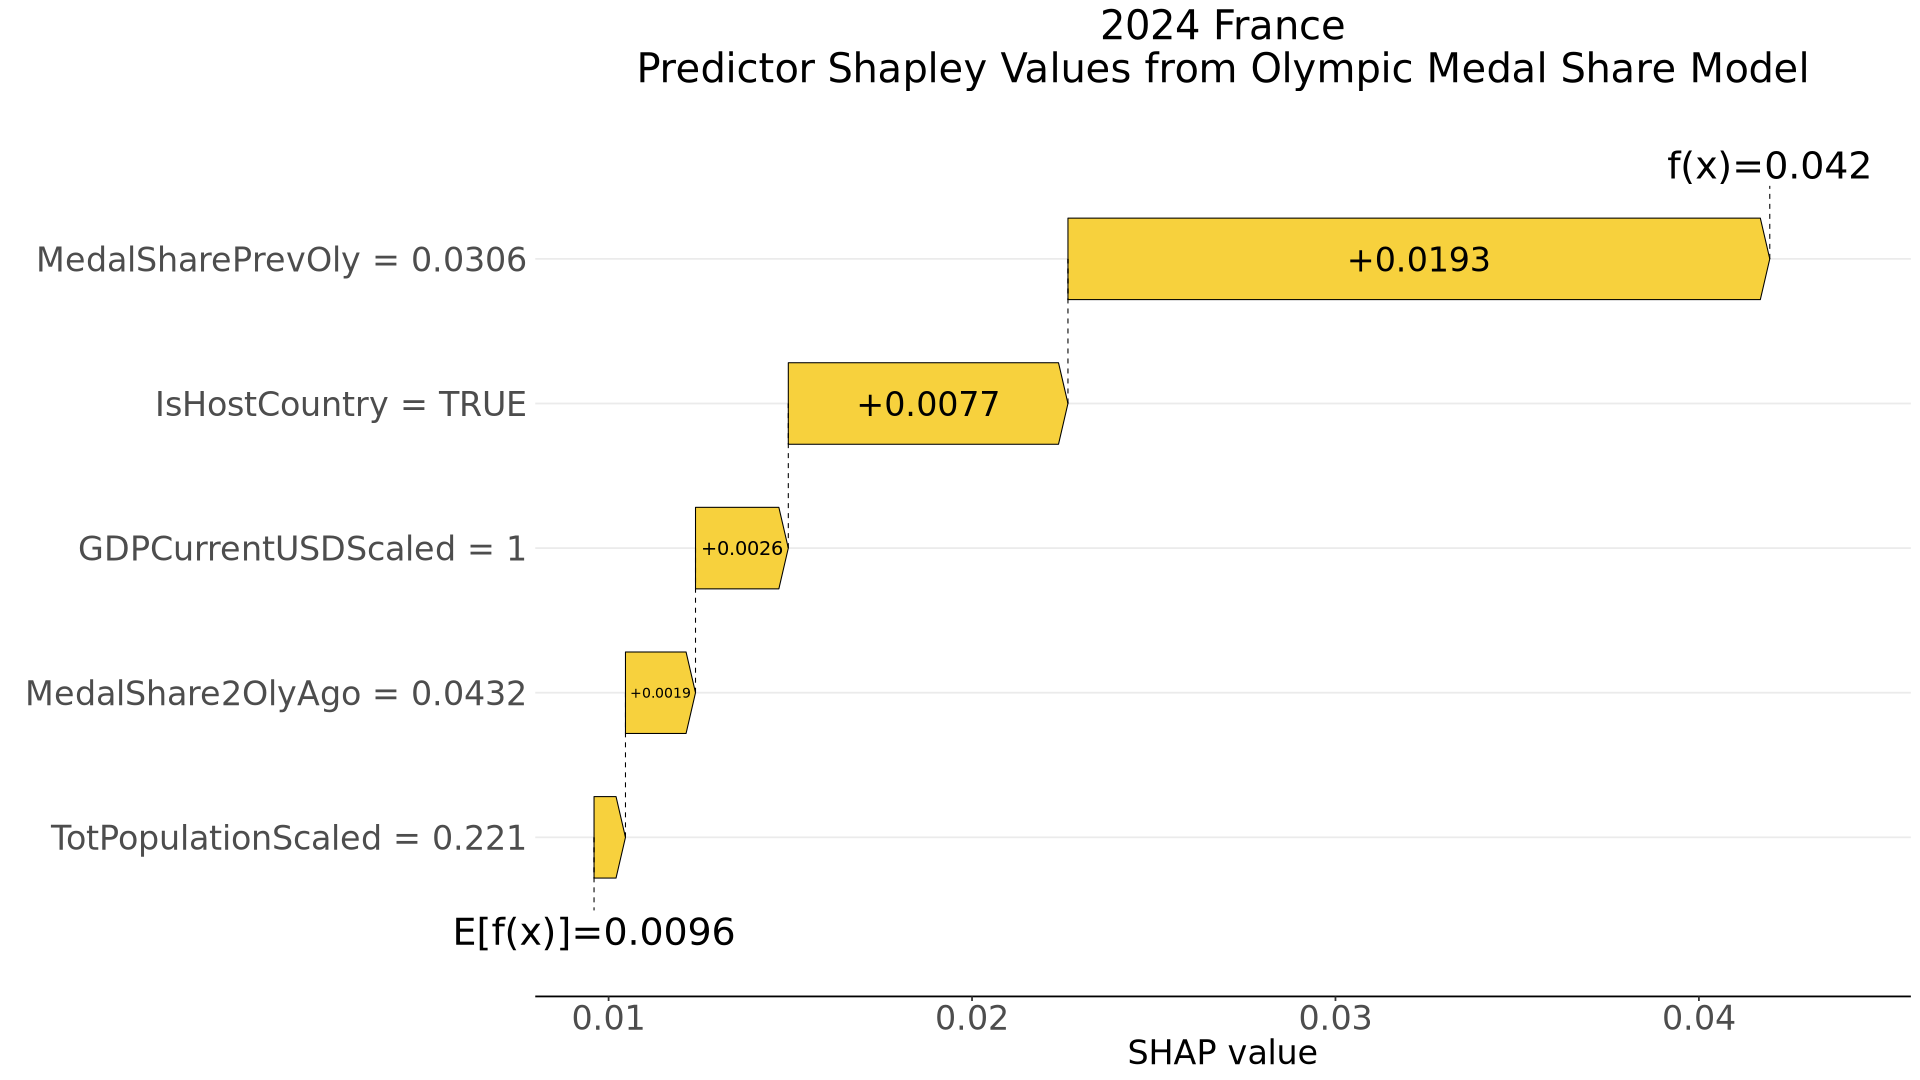

In [47]:
# Examine Predictions, Prediction Explanation, and Shapley Plot for 1 Chosen Country
YEAR <- 2024

COUNTRY <- "France"

this_country_year <- pred_year_country_medal_share_model_explain %>% 
  filter(Year == YEAR, Country == COUNTRY)

pred_medals_text <- this_country_year %>% pull(PredMedalsText)

cat(paste0(pred_medals_text, "\n\n"))

prediction_explanation <- this_country_year %>% pull(PredictionExplanation)

cat(paste0(prediction_explanation, "\n\n"))

predictor_shap_values_plot <- this_country_year %>% 
  pull(PredictorShapValuesPlot) %>% pluck(1)

plot(predictor_shap_values_plot)

# Get Country Olympic Performance vs Prediction Analysis and Plots

In [48]:
# Pivot country medals data into longer format, add in various ranks and things to help with plot
medal_cols <- c("Gold", "Silver", "Bronze", "Total", "Predicted", "Total vs Predicted")

GetRankOrdinalFromRank <- function(rank) {
  suffix <- case_when(
    (rank %% 100) %in% 11:13 ~ "th",
    (rank %% 10) == 1 ~ "st",
    (rank %% 10) == 2 ~ "nd",
    (rank %% 10) == 3 ~ "rd",
    TRUE ~ "th"
  )
  rank_ordinal <- paste0(rank, suffix)
    
  return(rank_ordinal)
}

country_medal_results_and_preds_long <- 
  # Start back with country medal prediction model results (don't need Shapley values here)
  country_medal_share_model_results %>%
  rename(Total = Medals, Predicted = PredMedals) %>%
  mutate(
    `Total vs Predicted` = Total - Predicted
    ) %>%
  select(Year, Country, all_of(medal_cols)) %>%
  pivot_longer(
    cols = all_of(medal_cols),
    names_to = "MedalsField",
    values_to = "MedalsValue"
    ) %>%
  mutate(
    MedalsField = factor(MedalsField, levels = medal_cols)
    ) %>%
  group_by(Year, MedalsField) %>%
  mutate(
    MedalsValueRk = rank(desc(MedalsValue), ties.method = "min", na.last = "keep"),
    MedalsValueNumAtRk = rank(desc(MedalsValue), ties.method = "max", na.last = "keep") 
      - MedalsValueRk + 1L,
    ) %>%
  arrange(desc(MedalsValue), Country) %>%
  mutate(
    MedalsValueUniqueRk = rank(row_number())
    ) %>%
  ungroup() %>%
  mutate(
    MedalsValueRkText = paste0(
      case_when(
        (MedalsField == 'Predicted') ~ sprintf('%.1f', MedalsValue), 
        (MedalsField == 'Total vs Predicted') ~ sprintf('%+.1f', MedalsValue), 
        TRUE ~ sprintf('%d', as.integer(MedalsValue))
        ),
      "\n",
      GetRankOrdinalFromRank(MedalsValueRk),
      ifelse(MedalsValueNumAtRk == 1, '', ' (tied)') 
      )
    ) %>%
  print()

# A tibble: 6,546 × 8
    Year Country       MedalsField MedalsValue MedalsValueRk MedalsValueNumAtRk
   <int> <chr>         <fct>             <dbl>         <int>              <int>
 1  2024 United States Total              126              1                  1
 2  2016 United States Total              121              1                  1
 3  1992 Unified Team  Predicted          115.             1                  1
 4  2020 United States Total              113              1                  1
 5  2020 United States Predicted          113.             1                  1
 6  1992 Unified Team  Total              112              1                  1
 7  2008 United States Total              112              1                  1
 8  1992 United States Predicted          110.             2                  1
 9  1992 United States Total              108              2                  1
10  2008 United States Predicted          105.             1                  1
   MedalsValueUniq

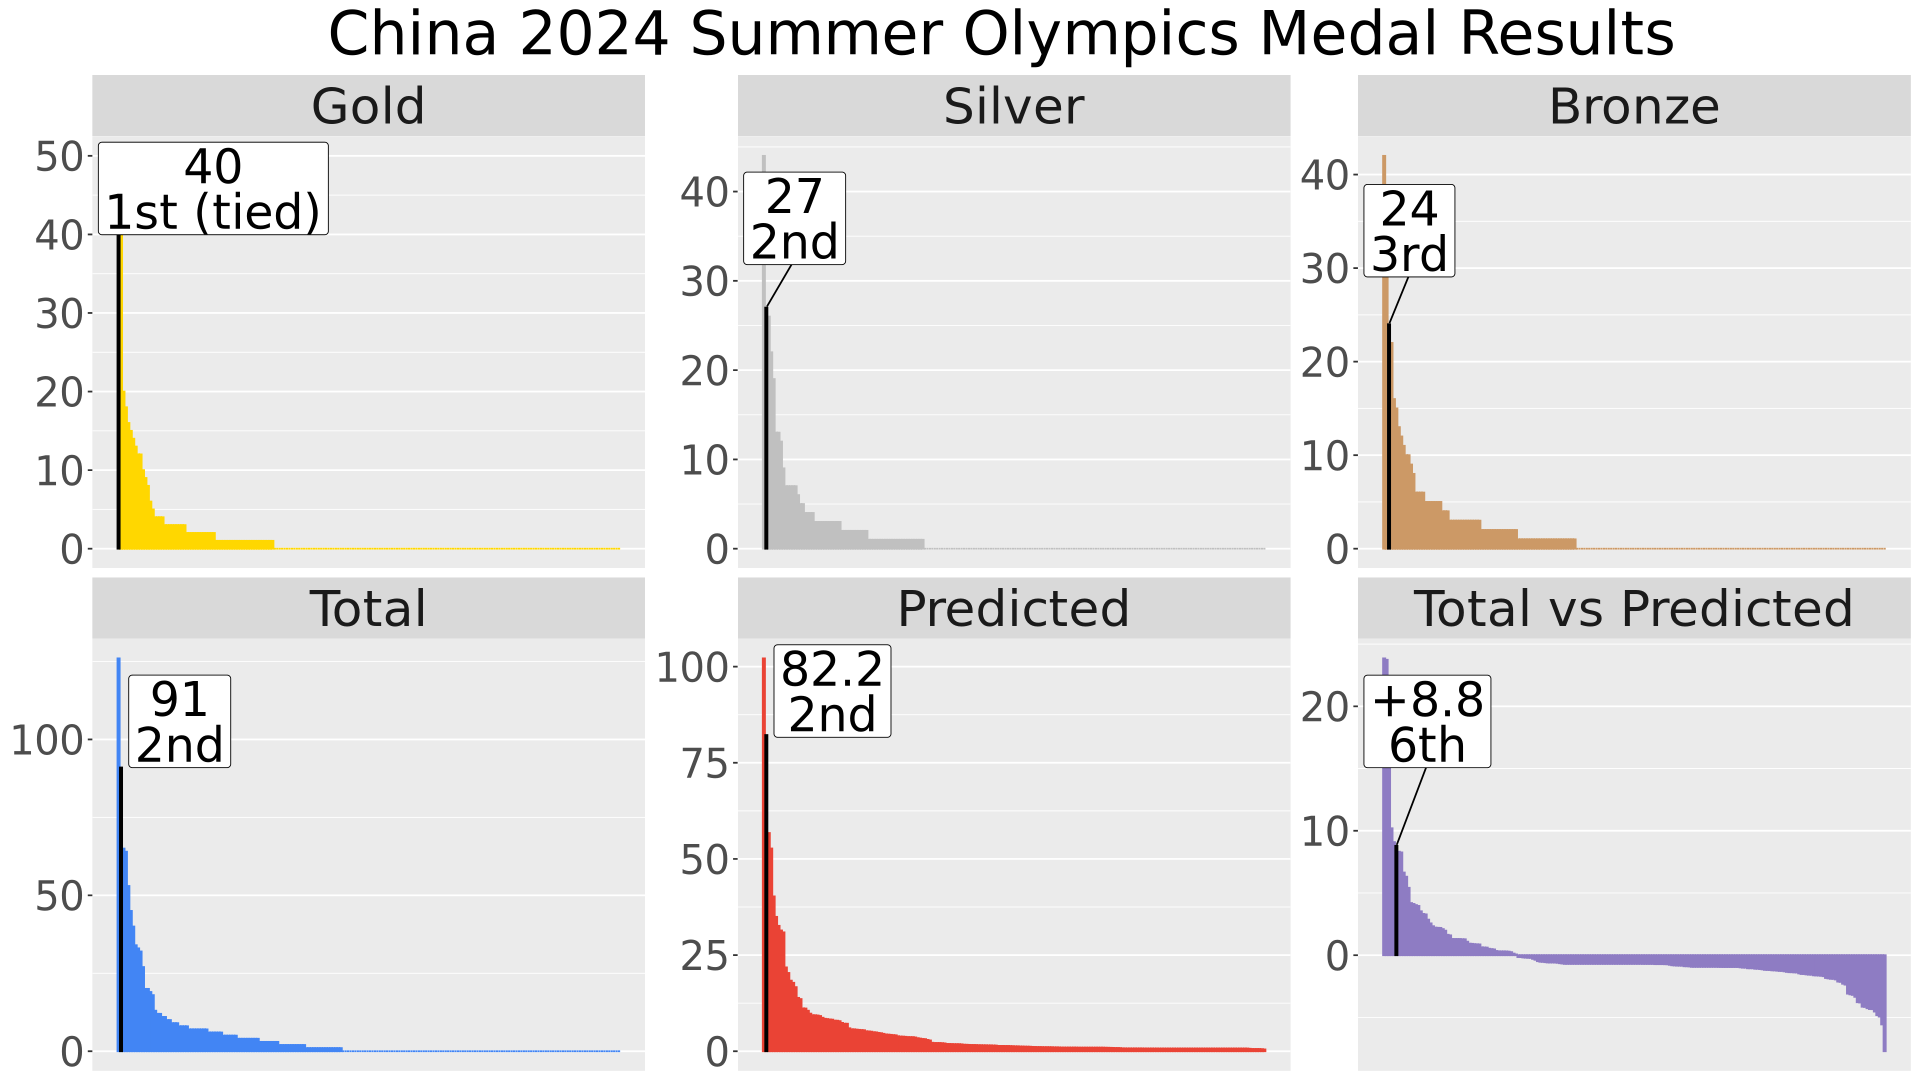

In [49]:
# Function to get plot of country's medals and results
GetCountryYearMedalResultsPlot <- function(year, country, 
  all_country_year_medal_results_long_data = country_medal_results_and_preds_long)
{
  this_year_medal_results_and_preds_long <- all_country_year_medal_results_long_data %>%
    filter(Year == year)

  this_country_medal_results_and_preds_long <- this_year_medal_results_and_preds_long %>%
    filter(Country == country)

  medal_fields_color_mapping <- c(
    "Gold" = "#ffd700", "Silver" = "#c0c0c0", "Bronze" = "#cc9966",
    "Total" = "#4285f4", "Predicted" = "#ea4335", "Total vs Predicted" = "#8e7cc3"
    )
    
  country_medal_results_and_preds_plot <- ggplot(
    data = this_year_medal_results_and_preds_long %>% 
      filter(Country != country)
    ) +
    geom_col(
      aes(x = MedalsValueUniqueRk, y = MedalsValue, col = MedalsField,
        fill = MedalsField), 
        show.legend = FALSE
      ) + 
    scale_color_manual(
      values = medal_fields_color_mapping,
      aesthetics = c("color", "fill")
      ) +    
    geom_col(
      data = this_country_medal_results_and_preds_long,
      aes(x = MedalsValueUniqueRk, y = MedalsValue),
      col = "black",
      fill = "black",
      show.legend = FALSE
      ) +     
    geom_label_repel(
      data = this_country_medal_results_and_preds_long,
      aes(x = MedalsValueUniqueRk, y = MedalsValue, label = MedalsValueRkText,
        #col = MedalsField
        ),
      col = "black",
      size = 10,
      lineheight = 0.8,
      nudge_y = 10,
      show.legend = FALSE
      ) +
    scale_x_continuous(labels = NULL, breaks = NULL) +    
    facet_wrap( ~ MedalsField, scales = "free_y") +
    labs(
      title = glue("{country} {year} Summer Olympics Medal Results"),
      x = NULL, 
      y = NULL
      ) 

  return(country_medal_results_and_preds_plot)
}

# Test on single year and country
YEAR <- 2024
COUNTRY <- "China"

(
country_year_medal_results_plot <- GetCountryYearMedalResultsPlot(
  YEAR, COUNTRY)
)

In [50]:
# Create medal results plot for each country year in prediction dataset
plan(multisession)

tic("Creating Medal Results Plots for Each Country Year")

pred_year_country_medal_results_plots <- country_medal_share_model_results %>%
  filter(TrainTestPredSplit == "Prediction") %>%
  mutate(
    CountryMedalResultsPlot = future_pmap(list(Year, Country), 
      GetCountryYearMedalResultsPlot),
    CountryMedalResultsPlotFileName = glue("{Year}_{str_replace_all(Country, ' ', '_')}_",
      "olympic_medal_results_plot.png") %>% 
      as.character(),
    CountryMedalResultsPlotGCSURI = glue("gs://{BUCKET_NAME}/{BUCKET_SUBDIR}/",
      "country_medal_results_plots/{CountryMedalResultsPlotFileName}") %>% 
      as.character()
    ) %>%
  print()

toc()

# A tibble: 206 × 36
    Year Country                     OlympicsCountryCode OlympicsCountryGroup
   <int> <chr>                       <chr>               <chr>               
 1  2024 Afghanistan                 AFG                 AFG                 
 2  2024 Individual Neutral Athletes AIN                 AIN                 
 3  2024 Albania                     ALB                 ALB                 
 4  2024 Algeria                     ALG                 ALG                 
 5  2024 Andorra                     AND                 AND                 
 6  2024 Angola                      ANG                 ANG                 
 7  2024 Antigua and Barbuda         ANT                 ANT                 
 8  2024 Argentina                   ARG                 ARG                 
 9  2024 Armenia                     ARM                 ARM                 
10  2024 Aruba                       ARU                 ARU                 
   IsHostCountry  Gold Silver Bronze Medals

In [51]:
# Output all country year medal results plots to specified location in Cloud Storage
# plan(multisession)

tic("Outputting Medal Results Plots for Each Country Year to Google Cloud Storage")

# Couldn't get multithreaded future_pwalk working as desired here, so sticking with pwalk
pwalk(
  with(pred_year_country_medal_results_plots,
    list(
      plot_object = CountryMedalResultsPlot,
      file_name = CountryMedalResultsPlotFileName,
      bucket_name = BUCKET_NAME,
      bucket_subdir = glue("{BUCKET_SUBDIR}/country_medal_results_plots") %>%
        as.character(),
      project_id = PROJECT_ID,
      plot_scale = 1,
      check_output_dir_after_write = FALSE,
      delete_local_file = TRUE      
      )
    ),
    UploadGGPlotObjectToCloudStorageBucket
  )

toc()

Outputting Medal Results Plots for Each Country Year to Google Cloud Storage: 1058.509 sec elapsed


# Use Gemini to Help Analyze/Look for Stories Across All Country Olympic Performance Plots

In [52]:
# Set up country medal results plots prompt and content list for Gemini
all_country_medal_results_plots_analysis_prompt <- glue(
  "You are a data scientist who does a great job of explaining various outputs from data analysis and ",
  "modeling, including numbers, tables, and plots, to help a more general audience understand your results ",
  "better.\n\n",
  "The plots included show each country's results from the 2024 Olympics. Each plot shows: ",
  "- The number of gold, silver, bronze medals (as well as rankings across all countries) in the top row.\n",
  "- The total medals won, a measure of overall performance, in the bottom left.\n",
  "- The predicted medals won by the country from our model before the Olympics, which takes into account ",
  "previous performance and other factors.\n",
  "- The difference between actual medals won and that country's pre-Olympics prediction - a measure of how ",
  "well a country did vs expectation. Positive numbers indicate more medals and better performance than ",
  "expected, while negative numbers indicate fewer medals and worse performance than expected.\n\n",
  "Please look through all of these plots carefully, and tell me which countries have interesting results ",
  "that would be worth writing about in a report summarizing the Olympic results. Focus specifically on ",
  "countries that had lots of medals (total or gold/silver/bronze) as well as countries that performed well ",
  "or poorly compared to expectations. Provide some talking points around the results for each of those ",
  "countries that references the various medal values in the country's plot, without being overly technical. ",
  "Be careful not to mix up medal counts and ranks across the different categories for each country.\n\n",

  "Stick to only the data and information in the plots provided in creating your response. ",
  "Your response should be understandable by a non-technical audience, 500 words or fewer, and in English.\n"
)

country_medal_results_plots_content_list <- pred_year_country_medal_results_plots %>%
  mutate(
    CountryMedalResultsPlotPromptPart = pmap(list(CountryMedalResultsPlotGCSURI),
      ~Part$from_uri(., mime_type = "image/png"))
    ) %>%
  pull(CountryMedalResultsPlotPromptPart)

cat("Prompt Text:\n")
cat(all_country_medal_results_plots_analysis_prompt)
cat("\n\nFirst Few Items in Prompt Content List:\n")
print(head(country_medal_results_plots_content_list, n = 3))

Prompt Text:
You are a data scientist who does a great job of explaining various outputs from data analysis and modeling, including numbers, tables, and plots, to help a more general audience understand your results better.

The plots included show each country's results from the 2024 Olympics. Each plot shows: - The number of gold, silver, bronze medals (as well as rankings across all countries) in the top row.
- The total medals won, a measure of overall performance, in the bottom left.
- The predicted medals won by the country from our model before the Olympics, which takes into account previous performance and other factors.
- The difference between actual medals won and that country's pre-Olympics prediction - a measure of how well a country did vs expectation. Positive numbers indicate more medals and better performance than expected, while negative numbers indicate fewer medals and worse performance than expected.

Please look through all of these plots carefully, and tell me wh

In [53]:
# Get analysis of all country medal results plots from Gemini
tic("Getting Analysis of All Country Medal Results Plots from Gemini")

# Use Gemini Pro model this time, as this requires more sophisticated reasoning across many images
all_country_medal_results_plots_analysis_response <- GeminiProModel$generate_content(
  contents = c(country_medal_results_plots_content_list,
    all_country_medal_results_plots_analysis_prompt),
  generation_config = GenerationConfig(
    temperature = 0
    )  
  )

all_country_medal_results_plots_analysis_response_text <- (
  all_country_medal_results_plots_analysis_response$text)
  
cat(all_country_medal_results_plots_analysis_response_text)

toc()

The 2024 Olympics saw some countries exceeding expectations and others falling short. Here are some highlights:

**Overachievers:**

* **South Korea** significantly outperformed predictions, earning a total of 32 medals, placing them 10th overall. This was a remarkable +10.2 medal difference from their predicted 21.8, landing them 4th in terms of exceeding expectations.
* **Kyrgyzstan** also punched above their weight, securing 6 medals and ranking 38th overall. Their +4 medal difference from the predicted 2 landed them in 15th place for exceeding expectations.
* **Bahrain** surprised with a total of 4 medals, placing 50th overall. This was a +3.5 medal difference from their predicted 0.5, putting them 16th in terms of exceeding expectations.

**Underachievers:**

* **Japan** fell short of expectations, earning a total of 45 medals and ranking 6th overall. Despite this seemingly strong performance, their -7.7 medal difference from the predicted 52.7 placed them 206th in terms of meetin